Побудувати CNN на основі Inception-ResNets для класифікації зображень на
основі датасету fashion-mnist. Зробити налаштування моделі для досягнення
необхідної точності. На базі Siamese networks побудувати систему для пошуку
подібних зображень в датасеті fashion-mnist. Візуалізувати отримані
результати t-SNE.

In [3]:
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Inception-ResNet-v1 uses the
blocks as described in Figures 14, 10, 7, 11, 12 and 13

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

from tqdm import tqdm
from google.colab import drive
import random

import numpy as np

In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([Resize((84, 84)), ToTensor(), Normalize((0.5,), (0.5,))])
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([Resize((84, 84)), ToTensor(), Normalize((0.5,), (0.5,))])
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12501275.77it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205371.20it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3923306.65it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5982897.48it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



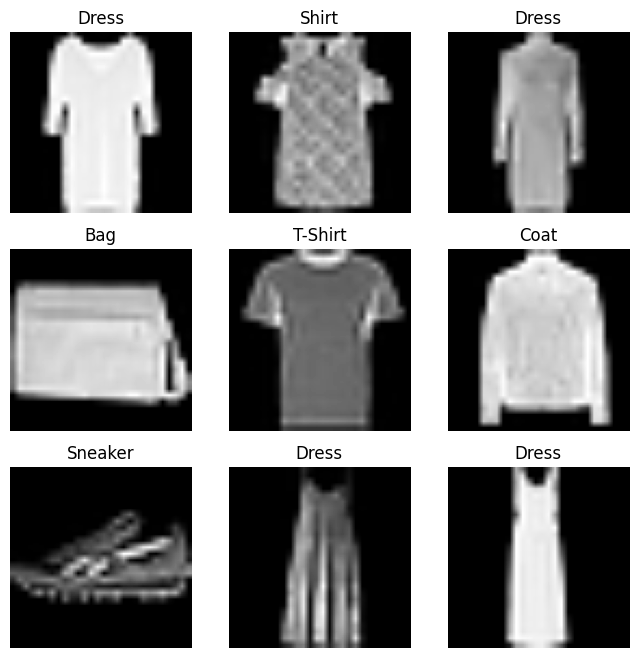

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
training_data[0][0].shape

torch.Size([1, 84, 84])

In [8]:
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [9]:
class Stem(nn.Module):
    def __init__(self):
        super(Stem, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=80, kernel_size=1),
            nn.Conv2d(in_channels=80, out_channels=192, kernel_size=3),
            nn.Conv2d(in_channels=192, out_channels=256, kernel_size=3, stride=2),
        )

    def forward(self, x):
        return self.stem(x)


In [10]:
class InceptionResNetA(nn.Module):
    def __init__(self, in_channels):
        super(InceptionResNetA, self).__init__()

        self.branch_0 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
        self.branch_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        )
        self.branch_2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        )

        self.last_conv = nn.Conv2d(in_channels=3*32, out_channels=in_channels, kernel_size=1)

    def forward(self, x):
        x = nn.functional.relu(x)

        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)

        x_res = torch.cat((x0, x1, x2), dim=1)
        x_res = self.last_conv(x_res)

        return nn.functional.relu(x + x_res)


In [11]:
class ReductionA(nn.Module):
    def __init__(self, in_channels, k, l, m, n):
        super(ReductionA, self).__init__()

        self.branch_0 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.branch_1 = nn.Conv2d(in_channels=in_channels, out_channels=n, kernel_size=3, stride=2)
        self.branch_2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=k, kernel_size=1),
            nn.Conv2d(in_channels=k, out_channels=l, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=l, out_channels=m, kernel_size=3, stride=2),
        )

        self.last_conv = nn.Conv2d(in_channels=3*32, out_channels=in_channels, kernel_size=1)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)

        return torch.cat((x0, x1, x2), dim=1)


In [12]:
class InceptionResNetB(nn.Module):
    def __init__(self, in_channels):
        super(InceptionResNetB, self).__init__()

        self.branch_0 = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=1)
        self.branch_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, 7), padding=(0, 3)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(7, 1), padding=(3, 0)),
        )

        self.last_conv = nn.Conv2d(in_channels=2*128, out_channels=in_channels, kernel_size=1)

    def forward(self, x):
        x = nn.functional.relu(x)

        x0 = self.branch_0(x)
        x1 = self.branch_1(x)

        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.last_conv(x_res)

        return nn.functional.relu(x + x_res)


In [13]:
class ReductionB(nn.Module):
    def __init__(self, in_channels):
        super(ReductionB, self).__init__()

        self.branch_0 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.branch_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=1),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=2),
        )
        self.branch_2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2),
        )
        self.branch_3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2),
        )

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)

        return torch.cat((x0, x1, x2, x3), dim=1)


In [14]:
class InceptionResNetC(nn.Module):
    def __init__(self, in_channels):
        super(InceptionResNetC, self).__init__()

        self.branch_0 = nn.Conv2d(in_channels=in_channels, out_channels=192, kernel_size=1, bias=False)
        self.branch_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=192, kernel_size=1, bias=False),
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(1, 3), padding=(0, 1), bias=False),
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(3, 1), padding=(1, 0), bias=False),
        )

        self.last_conv = nn.Conv2d(in_channels=2*192, out_channels=in_channels, kernel_size=1)

    def forward(self, x):
        x = nn.functional.relu(x)

        x0 = self.branch_0(x)
        x1 = self.branch_1(x)

        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.last_conv(x_res)

        return nn.functional.relu(x + x_res)


In [15]:
class InceptionResNet1(nn.Module):
    def __init__(self, head):
        super(InceptionResNet1, self).__init__()

        self.inceptionResNet1 = nn.Sequential(
            Stem(), # 256 x 35 x 35
            InceptionResNetA(256),
            InceptionResNetA(256),
            InceptionResNetA(256),
            InceptionResNetA(256),
            InceptionResNetA(256),
            ReductionA(256, 192, 192, 256, 384), # 896 x 17 x 17

            InceptionResNetB(896),
            InceptionResNetB(896),
            InceptionResNetB(896),
            InceptionResNetB(896),
            InceptionResNetB(896),
            InceptionResNetB(896),
            InceptionResNetB(896),
            InceptionResNetB(896),
            InceptionResNetB(896),
            InceptionResNetB(896),
            ReductionB(896), # 1792 x 8 x 8

            InceptionResNetC(1792),
            InceptionResNetC(1792),
            InceptionResNetC(1792),
            InceptionResNetC(1792),
            InceptionResNetC(1792),

            nn.AdaptiveAvgPool2d(output_size=(1,1)), # 1792 x 1 x 1

            nn.Dropout(0.2)
        )

        self.head = head

    def forward(self, x):
        return self.head(self.inceptionResNet1(x).view(-1, 1792))

# Classifier

In [45]:
irn1 = InceptionResNet1(head=nn.Sequential(nn.Linear(1792, 10), nn.LogSoftmax(-1))).to("cuda")
summary(irn1, input_size=(1, 1, 299, 299))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
InceptionResNet1                         [1, 10]                   --
├─Sequential: 1-1                        [1, 1792, 1, 1]           --
│    └─Stem: 2-1                         [1, 256, 35, 35]          --
│    │    └─Sequential: 3-1              [1, 256, 35, 35]          614,320
│    └─InceptionResNetA: 2-2             [1, 256, 35, 35]          --
│    │    └─Conv2d: 3-2                  [1, 32, 35, 35]           8,224
│    │    └─Sequential: 3-3              [1, 32, 35, 35]           17,472
│    │    └─Sequential: 3-4              [1, 32, 35, 35]           26,720
│    │    └─Conv2d: 3-5                  [1, 256, 35, 35]          24,832
│    └─InceptionResNetA: 2-3             [1, 256, 35, 35]          --
│    │    └─Conv2d: 3-6                  [1, 32, 35, 35]           8,224
│    │    └─Sequential: 3-7              [1, 32, 35, 35]           17,472
│    │    └─Sequential: 3-8              [1, 32, 35, 35]  

In [ ]:
summary(irn1, input_size=(1, 1, 84, 84))

Layer (type:depth-idx)                   Output Shape              Param #
InceptionResNet1                         [1, 10]                   --
├─Sequential: 1-1                        [1, 1792, 1, 1]           --
│    └─Stem: 2-1                         [1, 256, 8, 8]            --
│    │    └─Sequential: 3-1              [1, 256, 8, 8]            614,320
│    └─InceptionResNetA: 2-2             [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-2                  [1, 32, 8, 8]             8,224
│    │    └─Sequential: 3-3              [1, 32, 8, 8]             17,472
│    │    └─Sequential: 3-4              [1, 32, 8, 8]             26,720
│    │    └─Conv2d: 3-5                  [1, 256, 8, 8]            24,832
│    └─InceptionResNetA: 2-3             [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-6                  [1, 32, 8, 8]             8,224
│    │    └─Sequential: 3-7              [1, 32, 8, 8]             17,472
│    │    └─Sequential: 3-8              [1, 32, 8, 8]    

In [ ]:
def test_metrics(model):
    test_acc = 0
    test_loss = 0

    true_labels = []
    predicted = []

    model.train(False)
    for inputs, labels in test_dataloader:
        true_labels.append(labels)

        outputs = model(inputs.to("cuda"))

        test_loss += nn.functional.nll_loss(outputs, labels.to("cuda")).item()

        predicted.append(outputs.argmax(dim=-1).detach().cpu())

        test_acc += torch.sum(outputs.argmax(dim=-1) == labels.to("cuda")).item()

    f1_w = f1_score(torch.cat(true_labels), torch.cat(predicted), average="weighted")
    f1_macro = f1_score(torch.cat(true_labels), torch.cat(predicted), average="macro")


    return test_acc/len(test_data), test_loss, f1_w, f1_macro

In [ ]:
acc, test_loss, f1_w, f1_macro = test_metrics(irn1)

print(f"\nRandom initialized test accuracy: {acc:.3f} F1 weighted: {f1_w:.3f} F1 macro: {f1_macro:.3f} loss: {test_loss:.3f}\n")


Random initialized test accuracy: 0.100 F1 weighted: 0.018 F1 macro: 0.018 loss: 182.066



In [ ]:
optimizer = torch.optim.SGD(irn1.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 4, gamma = 0.5, verbose=True)

for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    train_acc = 0

    irn1.train(True)
    for i, data in enumerate(tqdm(train_dataloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = irn1(inputs)
        
        loss = nn.functional.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        predicted = outputs.argmax(dim=-1)
        train_acc += torch.sum(predicted == labels).item()
        
        # print statistics
        running_loss += loss.item()
        if i % 25 == 24:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f} acc: {train_acc/ 25 /inputs.shape[0]:.3f} ({train_acc})')
            running_loss = 0.0
            train_acc = 0


    scheduler.step()
    acc, test_loss, f1_w, f1_macro = test_metrics(irn1)

    print(f"\nTest accuracy: {acc:.3f} F1 weighted: {f1_w:.3f} F1 macro: {f1_macro:.3f} loss: {test_loss:.3f}\n")
    
    torch.save(irn1.state_dict(), f'irn1_weights_{epoch}.pth')



Adjusting learning rate of group 0 to 1.0000e-02.


  6%|▌         | 26/469 [00:04<01:08,  6.42it/s]

[1,    25] loss: 0.029 acc: 0.266 (341)


 11%|█         | 51/469 [00:08<01:12,  5.78it/s]

[1,    50] loss: 0.029 acc: 0.271 (347)


 16%|█▌        | 76/469 [00:12<01:01,  6.37it/s]

[1,    75] loss: 0.029 acc: 0.267 (342)


 22%|██▏       | 101/469 [00:16<00:58,  6.34it/s]

[1,   100] loss: 0.029 acc: 0.273 (349)


 27%|██▋       | 126/469 [00:20<00:58,  5.82it/s]

[1,   125] loss: 0.029 acc: 0.295 (378)


 32%|███▏      | 151/469 [00:24<00:49,  6.46it/s]

[1,   150] loss: 0.029 acc: 0.287 (367)


 38%|███▊      | 176/469 [00:28<00:45,  6.44it/s]

[1,   175] loss: 0.029 acc: 0.299 (383)


 43%|████▎     | 201/469 [00:31<00:44,  5.98it/s]

[1,   200] loss: 0.029 acc: 0.368 (471)


 48%|████▊     | 226/469 [00:36<00:40,  5.94it/s]

[1,   225] loss: 0.029 acc: 0.338 (432)


 54%|█████▎    | 251/469 [00:40<00:33,  6.50it/s]

[1,   250] loss: 0.029 acc: 0.375 (480)


 59%|█████▉    | 276/469 [00:44<00:29,  6.50it/s]

[1,   275] loss: 0.028 acc: 0.481 (616)


 64%|██████▍   | 301/469 [00:48<00:25,  6.50it/s]

[1,   300] loss: 0.028 acc: 0.536 (686)


 70%|██████▉   | 326/469 [00:52<00:21,  6.56it/s]

[1,   325] loss: 0.028 acc: 0.741 (949)


 75%|███████▍  | 351/469 [00:55<00:17,  6.59it/s]

[1,   350] loss: 0.026 acc: 0.755 (967)


 80%|████████  | 376/469 [01:00<00:14,  6.55it/s]

[1,   375] loss: 0.024 acc: 0.972 (1244)


 86%|████████▌ | 401/469 [01:03<00:10,  6.53it/s]

[1,   400] loss: 0.020 acc: 1.059 (1355)


 91%|█████████ | 426/469 [01:08<00:06,  6.60it/s]

[1,   425] loss: 0.018 acc: 1.222 (1564)


 96%|█████████▌| 451/469 [01:12<00:02,  6.55it/s]

[1,   450] loss: 0.016 acc: 1.334 (1708)


100%|██████████| 469/469 [01:15<00:00,  6.24it/s]


Adjusting learning rate of group 0 to 1.0000e-02.

Test accuracy: 0.607 F1 weighted: 0.589 F1 macro: 0.589 loss: 79.426



  6%|▌         | 26/469 [00:04<01:08,  6.49it/s]

[2,    25] loss: 0.013 acc: 1.491 (1909)


 11%|█         | 51/469 [00:08<01:04,  6.45it/s]

[2,    50] loss: 0.012 acc: 1.577 (2019)


 16%|█▌        | 76/469 [00:12<01:01,  6.39it/s]

[2,    75] loss: 0.012 acc: 1.569 (2008)


 22%|██▏       | 101/469 [00:16<00:56,  6.48it/s]

[2,   100] loss: 0.011 acc: 1.679 (2149)


 27%|██▋       | 126/469 [00:19<00:53,  6.47it/s]

[2,   125] loss: 0.011 acc: 1.709 (2187)


 32%|███▏      | 151/469 [00:23<00:49,  6.47it/s]

[2,   150] loss: 0.010 acc: 1.780 (2279)


 38%|███▊      | 176/469 [00:27<00:44,  6.55it/s]

[2,   175] loss: 0.010 acc: 1.774 (2271)


 43%|████▎     | 201/469 [00:31<00:40,  6.56it/s]

[2,   200] loss: 0.009 acc: 1.771 (2267)


 48%|████▊     | 226/469 [00:35<00:37,  6.52it/s]

[2,   225] loss: 0.009 acc: 1.786 (2286)


 54%|█████▎    | 251/469 [00:39<00:34,  6.41it/s]

[2,   250] loss: 0.009 acc: 1.763 (2257)


 59%|█████▉    | 276/469 [00:43<00:29,  6.59it/s]

[2,   275] loss: 0.009 acc: 1.853 (2372)


 64%|██████▍   | 301/469 [00:47<00:34,  4.92it/s]

[2,   300] loss: 0.009 acc: 1.848 (2365)


 70%|██████▉   | 326/469 [00:52<00:22,  6.23it/s]

[2,   325] loss: 0.008 acc: 1.857 (2377)


 75%|███████▍  | 351/469 [00:57<00:18,  6.48it/s]

[2,   350] loss: 0.008 acc: 1.857 (2377)


 80%|███████▉  | 375/469 [01:01<00:17,  5.33it/s]

[2,   375] loss: 0.008 acc: 1.879 (2405)


 85%|████████▌ | 400/469 [01:07<00:16,  4.13it/s]

[2,   400] loss: 0.008 acc: 1.898 (2430)


 91%|█████████ | 425/469 [01:11<00:06,  6.42it/s]

[2,   425] loss: 0.008 acc: 1.891 (2420)


 96%|█████████▌| 451/469 [01:17<00:02,  6.49it/s]

[2,   450] loss: 0.008 acc: 1.915 (2451)


100%|██████████| 469/469 [01:20<00:00,  5.83it/s]


Adjusting learning rate of group 0 to 1.0000e-02.

Test accuracy: 0.709 F1 weighted: 0.682 F1 macro: 0.682 loss: 61.984



  6%|▌         | 26/469 [00:04<01:14,  5.96it/s]

[3,    25] loss: 0.008 acc: 1.909 (2444)


 11%|█         | 50/469 [00:08<01:32,  4.53it/s]

[3,    50] loss: 0.008 acc: 1.931 (2472)


 16%|█▌        | 76/469 [00:14<01:51,  3.53it/s]

[3,    75] loss: 0.007 acc: 1.952 (2498)


 22%|██▏       | 101/469 [00:19<01:09,  5.29it/s]

[3,   100] loss: 0.007 acc: 1.923 (2462)


 27%|██▋       | 126/469 [00:23<00:52,  6.55it/s]

[3,   125] loss: 0.007 acc: 1.938 (2480)


 32%|███▏      | 150/469 [00:27<01:14,  4.27it/s]

[3,   150] loss: 0.007 acc: 1.941 (2485)


 38%|███▊      | 176/469 [00:32<00:45,  6.39it/s]

[3,   175] loss: 0.007 acc: 1.973 (2525)


 43%|████▎     | 201/469 [00:36<00:55,  4.84it/s]

[3,   200] loss: 0.007 acc: 1.971 (2523)


 48%|████▊     | 226/469 [00:41<00:37,  6.48it/s]

[3,   225] loss: 0.007 acc: 1.993 (2551)


 54%|█████▎    | 251/469 [00:45<00:33,  6.51it/s]

[3,   250] loss: 0.007 acc: 1.957 (2505)


 59%|█████▉    | 276/469 [00:49<00:33,  5.75it/s]

[3,   275] loss: 0.007 acc: 1.952 (2498)


 64%|██████▍   | 301/469 [00:54<00:29,  5.79it/s]

[3,   300] loss: 0.007 acc: 1.962 (2511)


 70%|██████▉   | 326/469 [00:58<00:27,  5.13it/s]

[3,   325] loss: 0.007 acc: 1.998 (2557)


 75%|███████▍  | 350/469 [01:03<00:27,  4.38it/s]

[3,   350] loss: 0.007 acc: 1.982 (2537)


 80%|████████  | 376/469 [01:09<00:14,  6.36it/s]

[3,   375] loss: 0.007 acc: 2.000 (2560)


 86%|████████▌ | 401/469 [01:13<00:10,  6.48it/s]

[3,   400] loss: 0.006 acc: 2.018 (2583)


 91%|█████████ | 426/469 [01:17<00:07,  6.01it/s]

[3,   425] loss: 0.006 acc: 2.007 (2569)


 96%|█████████▌| 451/469 [01:21<00:02,  6.38it/s]

[3,   450] loss: 0.007 acc: 1.962 (2511)


100%|██████████| 469/469 [01:24<00:00,  5.57it/s]


Adjusting learning rate of group 0 to 1.0000e-02.

Test accuracy: 0.795 F1 weighted: 0.787 F1 macro: 0.787 loss: 42.245



  6%|▌         | 26/469 [00:05<01:30,  4.89it/s]

[4,    25] loss: 0.006 acc: 2.024 (2591)


 11%|█         | 51/469 [00:09<01:13,  5.72it/s]

[4,    50] loss: 0.007 acc: 1.985 (2541)


 16%|█▌        | 76/469 [00:15<01:25,  4.59it/s]

[4,    75] loss: 0.006 acc: 2.025 (2592)


 22%|██▏       | 101/469 [00:19<00:57,  6.42it/s]

[4,   100] loss: 0.006 acc: 2.067 (2646)


 27%|██▋       | 126/469 [00:23<00:53,  6.43it/s]

[4,   125] loss: 0.006 acc: 2.012 (2575)


 32%|███▏      | 151/469 [00:27<00:49,  6.42it/s]

[4,   150] loss: 0.006 acc: 2.052 (2627)


 38%|███▊      | 176/469 [00:30<00:44,  6.55it/s]

[4,   175] loss: 0.006 acc: 2.002 (2562)


 43%|████▎     | 201/469 [00:34<00:41,  6.44it/s]

[4,   200] loss: 0.006 acc: 2.010 (2573)


 48%|████▊     | 226/469 [00:38<00:37,  6.47it/s]

[4,   225] loss: 0.006 acc: 2.091 (2677)


 54%|█████▎    | 251/469 [00:42<00:33,  6.48it/s]

[4,   250] loss: 0.006 acc: 2.038 (2608)


 59%|█████▉    | 276/469 [00:47<00:41,  4.61it/s]

[4,   275] loss: 0.006 acc: 2.026 (2593)


 64%|██████▍   | 301/469 [00:52<00:25,  6.48it/s]

[4,   300] loss: 0.006 acc: 2.059 (2635)


 70%|██████▉   | 326/469 [00:56<00:21,  6.53it/s]

[4,   325] loss: 0.006 acc: 2.065 (2643)


 75%|███████▍  | 351/469 [01:01<00:18,  6.38it/s]

[4,   350] loss: 0.006 acc: 2.039 (2610)


 80%|████████  | 376/469 [01:05<00:14,  6.59it/s]

[4,   375] loss: 0.006 acc: 2.053 (2628)


 86%|████████▌ | 401/469 [01:08<00:10,  6.52it/s]

[4,   400] loss: 0.006 acc: 2.082 (2665)


 91%|█████████ | 426/469 [01:12<00:06,  6.49it/s]

[4,   425] loss: 0.006 acc: 2.066 (2644)


 96%|█████████▌| 451/469 [01:16<00:02,  6.51it/s]

[4,   450] loss: 0.006 acc: 2.055 (2630)


100%|██████████| 469/469 [01:19<00:00,  5.90it/s]


Adjusting learning rate of group 0 to 5.0000e-03.

Test accuracy: 0.800 F1 weighted: 0.801 F1 macro: 0.801 loss: 41.213



  6%|▌         | 26/469 [00:04<01:24,  5.24it/s]

[5,    25] loss: 0.005 acc: 2.087 (2672)


 11%|█         | 51/469 [00:09<01:09,  6.02it/s]

[5,    50] loss: 0.005 acc: 2.113 (2705)


 16%|█▌        | 75/469 [00:14<01:21,  4.84it/s]

[5,    75] loss: 0.005 acc: 2.112 (2704)


 22%|██▏       | 101/469 [00:18<00:57,  6.40it/s]

[5,   100] loss: 0.005 acc: 2.121 (2715)


 27%|██▋       | 126/469 [00:22<00:55,  6.19it/s]

[5,   125] loss: 0.005 acc: 2.102 (2691)


 32%|███▏      | 151/469 [00:27<00:59,  5.31it/s]

[5,   150] loss: 0.005 acc: 2.118 (2711)


 37%|███▋      | 175/469 [00:33<01:02,  4.70it/s]

[5,   175] loss: 0.005 acc: 2.114 (2706)


 43%|████▎     | 201/469 [00:38<00:49,  5.37it/s]

[5,   200] loss: 0.005 acc: 2.112 (2704)


 48%|████▊     | 226/469 [00:42<00:37,  6.44it/s]

[5,   225] loss: 0.005 acc: 2.134 (2732)


 54%|█████▎    | 251/469 [00:46<00:38,  5.72it/s]

[5,   250] loss: 0.005 acc: 2.100 (2688)


 59%|█████▊    | 275/469 [00:51<00:53,  3.62it/s]

[5,   275] loss: 0.005 acc: 2.102 (2690)


 64%|██████▍   | 301/469 [00:55<00:26,  6.44it/s]

[5,   300] loss: 0.005 acc: 2.119 (2712)


 70%|██████▉   | 326/469 [00:59<00:22,  6.45it/s]

[5,   325] loss: 0.005 acc: 2.084 (2668)


 75%|███████▍  | 351/469 [01:03<00:18,  6.50it/s]

[5,   350] loss: 0.005 acc: 2.123 (2718)


 80%|████████  | 376/469 [01:07<00:14,  6.51it/s]

[5,   375] loss: 0.005 acc: 2.107 (2697)


 86%|████████▌ | 401/469 [01:11<00:10,  6.30it/s]

[5,   400] loss: 0.005 acc: 2.105 (2694)


 91%|█████████ | 426/469 [01:15<00:06,  6.49it/s]

[5,   425] loss: 0.005 acc: 2.101 (2689)


 96%|█████████▌| 451/469 [01:19<00:03,  5.74it/s]

[5,   450] loss: 0.005 acc: 2.131 (2728)


100%|██████████| 469/469 [01:24<00:00,  5.58it/s]


Adjusting learning rate of group 0 to 5.0000e-03.

Test accuracy: 0.837 F1 weighted: 0.825 F1 macro: 0.825 loss: 35.435



  6%|▌         | 26/469 [00:04<01:11,  6.23it/s]

[6,    25] loss: 0.005 acc: 2.145 (2746)


 11%|█         | 51/469 [00:08<01:11,  5.86it/s]

[6,    50] loss: 0.005 acc: 2.127 (2723)


 16%|█▌        | 76/469 [00:12<01:00,  6.49it/s]

[6,    75] loss: 0.005 acc: 2.147 (2748)


 22%|██▏       | 101/469 [00:16<00:56,  6.54it/s]

[6,   100] loss: 0.005 acc: 2.132 (2729)


 27%|██▋       | 126/469 [00:20<00:53,  6.47it/s]

[6,   125] loss: 0.005 acc: 2.134 (2732)


 32%|███▏      | 151/469 [00:24<00:52,  6.08it/s]

[6,   150] loss: 0.005 acc: 2.141 (2741)


 38%|███▊      | 176/469 [00:28<00:44,  6.51it/s]

[6,   175] loss: 0.005 acc: 2.088 (2673)


 43%|████▎     | 201/469 [00:32<00:41,  6.45it/s]

[6,   200] loss: 0.005 acc: 2.132 (2729)


 48%|████▊     | 226/469 [00:36<00:37,  6.44it/s]

[6,   225] loss: 0.005 acc: 2.120 (2714)


 54%|█████▎    | 251/469 [00:40<00:33,  6.54it/s]

[6,   250] loss: 0.005 acc: 2.095 (2681)


 59%|█████▉    | 276/469 [00:44<00:29,  6.46it/s]

[6,   275] loss: 0.005 acc: 2.127 (2722)


 64%|██████▍   | 301/469 [00:48<00:25,  6.57it/s]

[6,   300] loss: 0.005 acc: 2.113 (2705)


 70%|██████▉   | 326/469 [00:52<00:24,  5.77it/s]

[6,   325] loss: 0.005 acc: 2.138 (2737)


 75%|███████▍  | 351/469 [00:56<00:18,  6.47it/s]

[6,   350] loss: 0.005 acc: 2.138 (2737)


 80%|████████  | 376/469 [01:00<00:14,  6.53it/s]

[6,   375] loss: 0.005 acc: 2.150 (2752)


 86%|████████▌ | 401/469 [01:03<00:10,  6.42it/s]

[6,   400] loss: 0.005 acc: 2.122 (2716)


 91%|█████████ | 426/469 [01:08<00:06,  6.21it/s]

[6,   425] loss: 0.005 acc: 2.131 (2728)


 96%|█████████▌| 451/469 [01:11<00:02,  6.45it/s]

[6,   450] loss: 0.005 acc: 2.139 (2738)


100%|██████████| 469/469 [01:14<00:00,  6.28it/s]


Adjusting learning rate of group 0 to 5.0000e-03.

Test accuracy: 0.832 F1 weighted: 0.834 F1 macro: 0.834 loss: 35.384



  6%|▌         | 26/469 [00:04<01:08,  6.50it/s]

[7,    25] loss: 0.005 acc: 2.117 (2710)


 11%|█         | 51/469 [00:07<01:04,  6.43it/s]

[7,    50] loss: 0.005 acc: 2.134 (2731)


 16%|█▌        | 76/469 [00:12<01:00,  6.52it/s]

[7,    75] loss: 0.005 acc: 2.112 (2703)


 22%|██▏       | 101/469 [00:15<00:56,  6.56it/s]

[7,   100] loss: 0.005 acc: 2.147 (2748)


 27%|██▋       | 126/469 [00:19<00:53,  6.47it/s]

[7,   125] loss: 0.005 acc: 2.150 (2752)


 32%|███▏      | 151/469 [00:23<00:50,  6.28it/s]

[7,   150] loss: 0.005 acc: 2.118 (2711)


 38%|███▊      | 176/469 [00:27<00:45,  6.48it/s]

[7,   175] loss: 0.005 acc: 2.145 (2745)


 43%|████▎     | 201/469 [00:31<00:41,  6.45it/s]

[7,   200] loss: 0.004 acc: 2.184 (2796)


 48%|████▊     | 226/469 [00:35<00:38,  6.28it/s]

[7,   225] loss: 0.005 acc: 2.145 (2746)


 54%|█████▎    | 251/469 [00:39<00:33,  6.56it/s]

[7,   250] loss: 0.005 acc: 2.152 (2755)


 59%|█████▉    | 276/469 [00:43<00:29,  6.50it/s]

[7,   275] loss: 0.004 acc: 2.177 (2787)


 64%|██████▍   | 301/469 [00:47<00:27,  6.17it/s]

[7,   300] loss: 0.005 acc: 2.130 (2727)


 70%|██████▉   | 326/469 [00:51<00:21,  6.50it/s]

[7,   325] loss: 0.005 acc: 2.138 (2736)


 75%|███████▍  | 351/469 [00:55<00:18,  6.54it/s]

[7,   350] loss: 0.005 acc: 2.170 (2778)


 80%|████████  | 376/469 [01:01<00:14,  6.31it/s]

[7,   375] loss: 0.005 acc: 2.161 (2766)


 86%|████████▌ | 401/469 [01:05<00:10,  6.45it/s]

[7,   400] loss: 0.005 acc: 2.161 (2766)


 91%|█████████ | 426/469 [01:09<00:06,  6.49it/s]

[7,   425] loss: 0.005 acc: 2.151 (2753)


 96%|█████████▌| 451/469 [01:13<00:02,  6.40it/s]

[7,   450] loss: 0.005 acc: 2.155 (2759)


100%|██████████| 469/469 [01:16<00:00,  6.13it/s]


Adjusting learning rate of group 0 to 5.0000e-03.

Test accuracy: 0.847 F1 weighted: 0.849 F1 macro: 0.849 loss: 32.041



  6%|▌         | 26/469 [00:04<01:09,  6.39it/s]

[8,    25] loss: 0.005 acc: 2.150 (2752)


 11%|█         | 51/469 [00:08<01:04,  6.44it/s]

[8,    50] loss: 0.004 acc: 2.170 (2778)


 16%|█▌        | 76/469 [00:12<01:02,  6.34it/s]

[8,    75] loss: 0.005 acc: 2.117 (2710)


 22%|██▏       | 101/469 [00:16<00:57,  6.39it/s]

[8,   100] loss: 0.005 acc: 2.166 (2773)


 27%|██▋       | 126/469 [00:20<00:52,  6.53it/s]

[8,   125] loss: 0.004 acc: 2.181 (2792)


 32%|███▏      | 151/469 [00:24<00:48,  6.52it/s]

[8,   150] loss: 0.005 acc: 2.148 (2749)


 38%|███▊      | 176/469 [00:28<00:45,  6.40it/s]

[8,   175] loss: 0.005 acc: 2.148 (2750)


 43%|████▎     | 201/469 [00:32<00:40,  6.56it/s]

[8,   200] loss: 0.004 acc: 2.190 (2803)


 48%|████▊     | 226/469 [00:35<00:37,  6.50it/s]

[8,   225] loss: 0.005 acc: 2.122 (2716)


 54%|█████▎    | 251/469 [00:40<00:33,  6.48it/s]

[8,   250] loss: 0.004 acc: 2.163 (2769)


 59%|█████▉    | 276/469 [00:43<00:30,  6.35it/s]

[8,   275] loss: 0.005 acc: 2.179 (2789)


 64%|██████▍   | 301/469 [00:47<00:27,  6.02it/s]

[8,   300] loss: 0.004 acc: 2.163 (2769)


 70%|██████▉   | 326/469 [00:52<00:23,  6.17it/s]

[8,   325] loss: 0.005 acc: 2.166 (2773)


 75%|███████▍  | 351/469 [00:56<00:18,  6.47it/s]

[8,   350] loss: 0.005 acc: 2.150 (2752)


 80%|████████  | 376/469 [01:00<00:14,  6.51it/s]

[8,   375] loss: 0.005 acc: 2.164 (2770)


 86%|████████▌ | 401/469 [01:04<00:11,  5.90it/s]

[8,   400] loss: 0.004 acc: 2.159 (2764)


 91%|█████████ | 426/469 [01:08<00:06,  6.54it/s]

[8,   425] loss: 0.004 acc: 2.184 (2795)


 96%|█████████▌| 451/469 [01:12<00:02,  6.44it/s]

[8,   450] loss: 0.004 acc: 2.177 (2787)


100%|██████████| 469/469 [01:15<00:00,  6.24it/s]


Adjusting learning rate of group 0 to 2.5000e-03.

Test accuracy: 0.860 F1 weighted: 0.861 F1 macro: 0.861 loss: 30.376



  6%|▌         | 26/469 [00:04<01:09,  6.40it/s]

[9,    25] loss: 0.004 acc: 2.199 (2815)


 11%|█         | 51/469 [00:08<01:06,  6.27it/s]

[9,    50] loss: 0.004 acc: 2.191 (2805)


 16%|█▌        | 76/469 [00:12<01:01,  6.44it/s]

[9,    75] loss: 0.004 acc: 2.207 (2825)


 22%|██▏       | 101/469 [00:15<00:57,  6.38it/s]

[9,   100] loss: 0.004 acc: 2.183 (2794)


 27%|██▋       | 126/469 [00:20<00:56,  6.07it/s]

[9,   125] loss: 0.004 acc: 2.195 (2809)


 32%|███▏      | 151/469 [00:23<00:48,  6.50it/s]

[9,   150] loss: 0.004 acc: 2.191 (2804)


 38%|███▊      | 176/469 [00:27<00:45,  6.49it/s]

[9,   175] loss: 0.004 acc: 2.173 (2782)


 43%|████▎     | 201/469 [00:31<00:47,  5.64it/s]

[9,   200] loss: 0.004 acc: 2.177 (2786)


 48%|████▊     | 226/469 [00:35<00:41,  5.85it/s]

[9,   225] loss: 0.004 acc: 2.181 (2792)


 54%|█████▎    | 251/469 [00:39<00:33,  6.55it/s]

[9,   250] loss: 0.004 acc: 2.190 (2803)


 59%|█████▉    | 276/469 [00:43<00:33,  5.84it/s]

[9,   275] loss: 0.004 acc: 2.189 (2802)


 64%|██████▍   | 301/469 [00:47<00:26,  6.36it/s]

[9,   300] loss: 0.004 acc: 2.180 (2791)


 70%|██████▉   | 326/469 [00:51<00:22,  6.50it/s]

[9,   325] loss: 0.004 acc: 2.182 (2793)


 75%|███████▍  | 351/469 [00:55<00:20,  5.82it/s]

[9,   350] loss: 0.004 acc: 2.168 (2775)


 80%|████████  | 376/469 [00:59<00:14,  6.49it/s]

[9,   375] loss: 0.004 acc: 2.198 (2814)


 86%|████████▌ | 401/469 [01:03<00:10,  6.38it/s]

[9,   400] loss: 0.004 acc: 2.207 (2825)


 91%|█████████ | 426/469 [01:07<00:07,  5.81it/s]

[9,   425] loss: 0.004 acc: 2.198 (2814)


 96%|█████████▌| 451/469 [01:11<00:02,  6.54it/s]

[9,   450] loss: 0.004 acc: 2.203 (2820)


100%|██████████| 469/469 [01:14<00:00,  6.31it/s]


Adjusting learning rate of group 0 to 2.5000e-03.

Test accuracy: 0.871 F1 weighted: 0.870 F1 macro: 0.870 loss: 28.879



  6%|▌         | 26/469 [00:04<01:08,  6.47it/s]

[10,    25] loss: 0.004 acc: 2.197 (2812)


 11%|█         | 51/469 [00:07<01:04,  6.52it/s]

[10,    50] loss: 0.004 acc: 2.193 (2807)


 16%|█▌        | 76/469 [00:11<01:07,  5.80it/s]

[10,    75] loss: 0.004 acc: 2.199 (2815)


 22%|██▏       | 101/469 [00:15<00:58,  6.29it/s]

[10,   100] loss: 0.004 acc: 2.212 (2831)


 27%|██▋       | 126/469 [00:19<00:52,  6.51it/s]

[10,   125] loss: 0.004 acc: 2.195 (2810)


 32%|███▏      | 151/469 [00:23<00:58,  5.41it/s]

[10,   150] loss: 0.004 acc: 2.193 (2807)


 38%|███▊      | 176/469 [00:28<00:45,  6.43it/s]

[10,   175] loss: 0.004 acc: 2.195 (2810)


 43%|████▎     | 201/469 [00:32<00:41,  6.48it/s]

[10,   200] loss: 0.004 acc: 2.207 (2825)


 48%|████▊     | 226/469 [00:36<00:39,  6.20it/s]

[10,   225] loss: 0.004 acc: 2.188 (2800)


 54%|█████▎    | 251/469 [00:40<00:33,  6.42it/s]

[10,   250] loss: 0.004 acc: 2.212 (2831)


 59%|█████▉    | 276/469 [00:44<00:29,  6.53it/s]

[10,   275] loss: 0.004 acc: 2.161 (2766)


 64%|██████▍   | 301/469 [00:47<00:25,  6.49it/s]

[10,   300] loss: 0.004 acc: 2.205 (2822)


 70%|██████▉   | 326/469 [00:52<00:21,  6.52it/s]

[10,   325] loss: 0.004 acc: 2.180 (2791)


 75%|███████▍  | 351/469 [00:56<00:18,  6.37it/s]

[10,   350] loss: 0.004 acc: 2.191 (2805)


 80%|████████  | 376/469 [00:59<00:14,  6.47it/s]

[10,   375] loss: 0.004 acc: 2.190 (2803)


 86%|████████▌ | 401/469 [01:04<00:10,  6.38it/s]

[10,   400] loss: 0.004 acc: 2.198 (2813)


 91%|█████████ | 426/469 [01:07<00:06,  6.38it/s]

[10,   425] loss: 0.004 acc: 2.180 (2790)


 96%|█████████▌| 451/469 [01:11<00:02,  6.54it/s]

[10,   450] loss: 0.004 acc: 2.191 (2805)


100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


Adjusting learning rate of group 0 to 2.5000e-03.

Test accuracy: 0.871 F1 weighted: 0.871 F1 macro: 0.871 loss: 28.397



  6%|▌         | 26/469 [00:04<01:10,  6.25it/s]

[11,    25] loss: 0.004 acc: 2.220 (2842)


 11%|█         | 50/469 [00:08<01:04,  6.45it/s]

[11,    50] loss: 0.004 acc: 2.209 (2828)


 16%|█▌        | 76/469 [00:12<01:00,  6.47it/s]

[11,    75] loss: 0.004 acc: 2.202 (2819)


 22%|██▏       | 101/469 [00:16<00:57,  6.41it/s]

[11,   100] loss: 0.004 acc: 2.226 (2849)


 27%|██▋       | 126/469 [00:20<00:53,  6.39it/s]

[11,   125] loss: 0.004 acc: 2.197 (2812)


 32%|███▏      | 151/469 [00:24<00:49,  6.47it/s]

[11,   150] loss: 0.004 acc: 2.206 (2824)


 38%|███▊      | 176/469 [00:27<00:44,  6.53it/s]

[11,   175] loss: 0.004 acc: 2.218 (2839)


 43%|████▎     | 201/469 [00:32<00:47,  5.59it/s]

[11,   200] loss: 0.004 acc: 2.197 (2812)


 48%|████▊     | 226/469 [00:36<00:37,  6.46it/s]

[11,   225] loss: 0.004 acc: 2.171 (2779)


 54%|█████▎    | 251/469 [00:40<00:33,  6.53it/s]

[11,   250] loss: 0.004 acc: 2.195 (2810)


 59%|█████▉    | 276/469 [00:44<00:33,  5.80it/s]

[11,   275] loss: 0.004 acc: 2.205 (2822)


 64%|██████▍   | 301/469 [00:48<00:26,  6.27it/s]

[11,   300] loss: 0.004 acc: 2.186 (2798)


 70%|██████▉   | 326/469 [00:52<00:22,  6.44it/s]

[11,   325] loss: 0.004 acc: 2.198 (2813)


 75%|███████▍  | 351/469 [00:56<00:20,  5.69it/s]

[11,   350] loss: 0.004 acc: 2.182 (2793)


 80%|████████  | 376/469 [01:00<00:14,  6.47it/s]

[11,   375] loss: 0.004 acc: 2.178 (2788)


 86%|████████▌ | 401/469 [01:04<00:10,  6.41it/s]

[11,   400] loss: 0.004 acc: 2.203 (2820)


 91%|█████████ | 426/469 [01:08<00:07,  5.86it/s]

[11,   425] loss: 0.004 acc: 2.209 (2827)


 96%|█████████▌| 451/469 [01:12<00:02,  6.41it/s]

[11,   450] loss: 0.004 acc: 2.199 (2815)


100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


Adjusting learning rate of group 0 to 2.5000e-03.

Test accuracy: 0.874 F1 weighted: 0.874 F1 macro: 0.874 loss: 27.797



  6%|▌         | 26/469 [00:04<01:09,  6.35it/s]

[12,    25] loss: 0.004 acc: 2.185 (2797)


 11%|█         | 51/469 [00:07<01:04,  6.50it/s]

[12,    50] loss: 0.004 acc: 2.203 (2820)


 16%|█▌        | 76/469 [00:11<01:07,  5.84it/s]

[12,    75] loss: 0.004 acc: 2.202 (2818)


 22%|██▏       | 101/469 [00:15<00:56,  6.52it/s]

[12,   100] loss: 0.004 acc: 2.190 (2803)


 27%|██▋       | 126/469 [00:20<00:53,  6.36it/s]

[12,   125] loss: 0.004 acc: 2.200 (2816)


 32%|███▏      | 151/469 [00:24<00:55,  5.75it/s]

[12,   150] loss: 0.004 acc: 2.235 (2861)


 38%|███▊      | 176/469 [00:28<00:45,  6.46it/s]

[12,   175] loss: 0.004 acc: 2.191 (2804)


 43%|████▎     | 201/469 [00:31<00:41,  6.50it/s]

[12,   200] loss: 0.004 acc: 2.214 (2834)


 48%|████▊     | 226/469 [00:35<00:41,  5.89it/s]

[12,   225] loss: 0.004 acc: 2.220 (2841)


 54%|█████▎    | 251/469 [00:39<00:33,  6.51it/s]

[12,   250] loss: 0.004 acc: 2.200 (2816)


 59%|█████▉    | 276/469 [00:43<00:30,  6.42it/s]

[12,   275] loss: 0.004 acc: 2.189 (2802)


 64%|██████▍   | 301/469 [00:47<00:29,  5.68it/s]

[12,   300] loss: 0.004 acc: 2.203 (2820)


 70%|██████▉   | 326/469 [00:51<00:22,  6.40it/s]

[12,   325] loss: 0.004 acc: 2.220 (2842)


 75%|███████▍  | 351/469 [00:55<00:18,  6.54it/s]

[12,   350] loss: 0.004 acc: 2.198 (2814)


 80%|████████  | 376/469 [00:59<00:15,  6.04it/s]

[12,   375] loss: 0.004 acc: 2.213 (2833)


 86%|████████▌ | 401/469 [01:03<00:10,  6.55it/s]

[12,   400] loss: 0.004 acc: 2.210 (2829)


 91%|█████████ | 426/469 [01:07<00:06,  6.48it/s]

[12,   425] loss: 0.004 acc: 2.225 (2848)


 96%|█████████▌| 451/469 [01:11<00:02,  6.19it/s]

[12,   450] loss: 0.004 acc: 2.205 (2822)


100%|██████████| 469/469 [01:14<00:00,  6.29it/s]


Adjusting learning rate of group 0 to 1.2500e-03.

Test accuracy: 0.875 F1 weighted: 0.872 F1 macro: 0.872 loss: 27.790



  5%|▌         | 25/469 [00:03<01:18,  5.64it/s]

[13,    25] loss: 0.004 acc: 2.215 (2835)


 11%|█         | 51/469 [00:08<01:05,  6.43it/s]

[13,    50] loss: 0.004 acc: 2.241 (2868)


 16%|█▌        | 76/469 [00:12<01:00,  6.52it/s]

[13,    75] loss: 0.004 acc: 2.221 (2843)


 22%|██▏       | 101/469 [00:16<00:55,  6.60it/s]

[13,   100] loss: 0.004 acc: 2.211 (2830)


 27%|██▋       | 126/469 [00:20<00:53,  6.44it/s]

[13,   125] loss: 0.004 acc: 2.229 (2853)


 32%|███▏      | 151/469 [00:24<00:49,  6.42it/s]

[13,   150] loss: 0.004 acc: 2.214 (2834)


 38%|███▊      | 176/469 [00:28<00:45,  6.40it/s]

[13,   175] loss: 0.004 acc: 2.223 (2846)


 43%|████▎     | 201/469 [00:32<00:42,  6.28it/s]

[13,   200] loss: 0.004 acc: 2.223 (2846)


 48%|████▊     | 226/469 [00:36<00:38,  6.38it/s]

[13,   225] loss: 0.004 acc: 2.216 (2836)


 54%|█████▎    | 251/469 [00:40<00:34,  6.31it/s]

[13,   250] loss: 0.004 acc: 2.225 (2848)


 59%|█████▉    | 276/469 [00:44<00:31,  6.14it/s]

[13,   275] loss: 0.004 acc: 2.248 (2877)


 64%|██████▍   | 301/469 [00:48<00:25,  6.58it/s]

[13,   300] loss: 0.004 acc: 2.234 (2860)


 70%|██████▉   | 326/469 [00:51<00:22,  6.46it/s]

[13,   325] loss: 0.004 acc: 2.212 (2832)


 75%|███████▍  | 351/469 [00:56<00:20,  5.68it/s]

[13,   350] loss: 0.004 acc: 2.230 (2855)


 80%|████████  | 376/469 [00:59<00:14,  6.45it/s]

[13,   375] loss: 0.004 acc: 2.223 (2845)


 86%|████████▌ | 401/469 [01:03<00:10,  6.54it/s]

[13,   400] loss: 0.004 acc: 2.231 (2856)


 91%|█████████ | 426/469 [01:07<00:07,  5.76it/s]

[13,   425] loss: 0.004 acc: 2.200 (2816)


 96%|█████████▌| 451/469 [01:12<00:03,  5.65it/s]

[13,   450] loss: 0.004 acc: 2.220 (2842)


100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


Adjusting learning rate of group 0 to 1.2500e-03.

Test accuracy: 0.875 F1 weighted: 0.872 F1 macro: 0.872 loss: 27.778



  6%|▌         | 26/469 [00:04<01:08,  6.48it/s]

[14,    25] loss: 0.004 acc: 2.234 (2859)


 11%|█         | 51/469 [00:07<01:06,  6.32it/s]

[14,    50] loss: 0.004 acc: 2.206 (2824)


 16%|█▌        | 76/469 [00:12<01:05,  6.03it/s]

[14,    75] loss: 0.004 acc: 2.229 (2853)


 22%|██▏       | 101/469 [00:16<00:57,  6.45it/s]

[14,   100] loss: 0.004 acc: 2.245 (2874)


 27%|██▋       | 126/469 [00:19<00:53,  6.44it/s]

[14,   125] loss: 0.004 acc: 2.230 (2855)


 32%|███▏      | 151/469 [00:24<00:53,  5.93it/s]

[14,   150] loss: 0.004 acc: 2.201 (2817)


 38%|███▊      | 176/469 [00:27<00:44,  6.51it/s]

[14,   175] loss: 0.004 acc: 2.220 (2842)


 43%|████▎     | 201/469 [00:31<00:41,  6.43it/s]

[14,   200] loss: 0.004 acc: 2.227 (2851)


 48%|████▊     | 226/469 [00:35<00:41,  5.80it/s]

[14,   225] loss: 0.004 acc: 2.223 (2846)


 54%|█████▎    | 251/469 [00:39<00:33,  6.51it/s]

[14,   250] loss: 0.004 acc: 2.240 (2867)


 59%|█████▉    | 276/469 [00:43<00:29,  6.51it/s]

[14,   275] loss: 0.004 acc: 2.215 (2835)


 64%|██████▍   | 301/469 [00:47<00:29,  5.78it/s]

[14,   300] loss: 0.004 acc: 2.230 (2854)


 70%|██████▉   | 326/469 [00:51<00:22,  6.42it/s]

[14,   325] loss: 0.004 acc: 2.227 (2851)


 75%|███████▍  | 351/469 [00:55<00:18,  6.37it/s]

[14,   350] loss: 0.004 acc: 2.215 (2835)


 80%|████████  | 376/469 [00:59<00:17,  5.43it/s]

[14,   375] loss: 0.004 acc: 2.230 (2855)


 86%|████████▌ | 401/469 [01:04<00:10,  6.34it/s]

[14,   400] loss: 0.004 acc: 2.227 (2851)


 91%|█████████ | 426/469 [01:07<00:06,  6.46it/s]

[14,   425] loss: 0.004 acc: 2.245 (2874)


 96%|█████████▌| 451/469 [01:11<00:02,  6.09it/s]

[14,   450] loss: 0.004 acc: 2.225 (2848)


100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


Adjusting learning rate of group 0 to 1.2500e-03.

Test accuracy: 0.871 F1 weighted: 0.873 F1 macro: 0.873 loss: 27.978



  6%|▌         | 26/469 [00:04<01:15,  5.85it/s]

[15,    25] loss: 0.004 acc: 2.212 (2831)


 11%|█         | 51/469 [00:08<01:04,  6.50it/s]

[15,    50] loss: 0.004 acc: 2.253 (2884)


 16%|█▌        | 76/469 [00:12<01:00,  6.54it/s]

[15,    75] loss: 0.004 acc: 2.216 (2837)


 22%|██▏       | 101/469 [00:15<01:02,  5.88it/s]

[15,   100] loss: 0.004 acc: 2.220 (2842)


 27%|██▋       | 126/469 [00:20<00:52,  6.48it/s]

[15,   125] loss: 0.004 acc: 2.212 (2832)


 32%|███▏      | 151/469 [00:23<00:49,  6.43it/s]

[15,   150] loss: 0.004 acc: 2.228 (2852)


 38%|███▊      | 176/469 [00:27<00:49,  5.98it/s]

[15,   175] loss: 0.004 acc: 2.234 (2859)


 43%|████▎     | 201/469 [00:31<00:41,  6.46it/s]

[15,   200] loss: 0.004 acc: 2.233 (2858)


 48%|████▊     | 226/469 [00:35<00:37,  6.46it/s]

[15,   225] loss: 0.004 acc: 2.238 (2865)


 54%|█████▎    | 251/469 [00:39<00:33,  6.48it/s]

[15,   250] loss: 0.004 acc: 2.239 (2866)


 59%|█████▉    | 276/469 [00:43<00:30,  6.39it/s]

[15,   275] loss: 0.004 acc: 2.208 (2826)


 64%|██████▍   | 301/469 [00:48<00:26,  6.41it/s]

[15,   300] loss: 0.004 acc: 2.226 (2849)


 70%|██████▉   | 326/469 [00:51<00:22,  6.41it/s]

[15,   325] loss: 0.004 acc: 2.237 (2863)


 75%|███████▍  | 351/469 [00:56<00:18,  6.38it/s]

[15,   350] loss: 0.004 acc: 2.235 (2861)


 80%|████████  | 376/469 [01:00<00:14,  6.37it/s]

[15,   375] loss: 0.004 acc: 2.229 (2853)


 86%|████████▌ | 401/469 [01:03<00:10,  6.40it/s]

[15,   400] loss: 0.004 acc: 2.246 (2875)


 91%|█████████ | 426/469 [01:08<00:06,  6.41it/s]

[15,   425] loss: 0.004 acc: 2.230 (2854)


 96%|█████████▌| 451/469 [01:12<00:02,  6.36it/s]

[15,   450] loss: 0.003 acc: 2.246 (2875)


100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


Adjusting learning rate of group 0 to 1.2500e-03.

Test accuracy: 0.879 F1 weighted: 0.880 F1 macro: 0.880 loss: 26.616



  6%|▌         | 26/469 [00:04<01:09,  6.35it/s]

[16,    25] loss: 0.004 acc: 2.230 (2854)


 11%|█         | 51/469 [00:07<01:08,  6.08it/s]

[16,    50] loss: 0.004 acc: 2.237 (2863)


 16%|█▌        | 76/469 [00:14<01:25,  4.59it/s]

[16,    75] loss: 0.003 acc: 2.245 (2874)


 22%|██▏       | 101/469 [00:18<00:56,  6.46it/s]

[16,   100] loss: 0.004 acc: 2.246 (2875)


 27%|██▋       | 126/469 [00:22<00:59,  5.75it/s]

[16,   125] loss: 0.004 acc: 2.212 (2831)


 32%|███▏      | 151/469 [00:26<00:50,  6.36it/s]

[16,   150] loss: 0.004 acc: 2.222 (2844)


 38%|███▊      | 176/469 [00:30<00:46,  6.34it/s]

[16,   175] loss: 0.004 acc: 2.204 (2821)


 43%|████▎     | 201/469 [00:34<00:45,  5.83it/s]

[16,   200] loss: 0.004 acc: 2.223 (2846)


 48%|████▊     | 226/469 [00:38<00:37,  6.46it/s]

[16,   225] loss: 0.004 acc: 2.245 (2873)


 54%|█████▎    | 251/469 [00:42<00:34,  6.37it/s]

[16,   250] loss: 0.003 acc: 2.244 (2872)


 59%|█████▉    | 276/469 [00:46<00:32,  5.86it/s]

[16,   275] loss: 0.004 acc: 2.218 (2839)


 64%|██████▍   | 300/469 [00:50<00:33,  5.11it/s]

[16,   300] loss: 0.003 acc: 2.228 (2852)


 70%|██████▉   | 326/469 [00:55<00:29,  4.82it/s]

[16,   325] loss: 0.003 acc: 2.246 (2875)


 75%|███████▍  | 351/469 [01:01<00:18,  6.24it/s]

[16,   350] loss: 0.004 acc: 2.235 (2861)


 80%|████████  | 376/469 [01:05<00:14,  6.40it/s]

[16,   375] loss: 0.004 acc: 2.234 (2859)


 86%|████████▌ | 401/469 [01:09<00:12,  5.49it/s]

[16,   400] loss: 0.004 acc: 2.241 (2868)


 91%|█████████ | 426/469 [01:14<00:06,  6.32it/s]

[16,   425] loss: 0.004 acc: 2.226 (2849)


 96%|█████████▌| 451/469 [01:18<00:02,  6.45it/s]

[16,   450] loss: 0.004 acc: 2.223 (2846)


100%|██████████| 469/469 [01:21<00:00,  5.77it/s]


Adjusting learning rate of group 0 to 6.2500e-04.

Test accuracy: 0.880 F1 weighted: 0.880 F1 macro: 0.880 loss: 26.510



  6%|▌         | 26/469 [00:04<01:09,  6.42it/s]

[17,    25] loss: 0.004 acc: 2.227 (2851)


 11%|█         | 51/469 [00:08<01:11,  5.86it/s]

[17,    50] loss: 0.004 acc: 2.248 (2878)


 16%|█▌        | 76/469 [00:12<01:08,  5.76it/s]

[17,    75] loss: 0.003 acc: 2.255 (2886)


 22%|██▏       | 101/469 [00:16<00:56,  6.48it/s]

[17,   100] loss: 0.004 acc: 2.238 (2865)


 27%|██▋       | 126/469 [00:20<00:58,  5.86it/s]

[17,   125] loss: 0.004 acc: 2.227 (2850)


 32%|███▏      | 151/469 [00:24<00:49,  6.43it/s]

[17,   150] loss: 0.003 acc: 2.249 (2879)


 37%|███▋      | 175/469 [00:28<01:01,  4.78it/s]

[17,   175] loss: 0.004 acc: 2.215 (2835)


 43%|████▎     | 201/469 [00:33<00:49,  5.45it/s]

[17,   200] loss: 0.003 acc: 2.251 (2881)


 48%|████▊     | 226/469 [00:37<00:37,  6.44it/s]

[17,   225] loss: 0.003 acc: 2.252 (2882)


 54%|█████▎    | 251/469 [00:41<00:33,  6.52it/s]

[17,   250] loss: 0.004 acc: 2.240 (2867)


 59%|█████▉    | 276/469 [00:45<00:32,  5.87it/s]

[17,   275] loss: 0.004 acc: 2.239 (2866)


 64%|██████▍   | 301/469 [00:49<00:25,  6.48it/s]

[17,   300] loss: 0.003 acc: 2.254 (2885)


 70%|██████▉   | 326/469 [00:53<00:22,  6.48it/s]

[17,   325] loss: 0.004 acc: 2.240 (2867)


 75%|███████▍  | 351/469 [00:57<00:20,  5.79it/s]

[17,   350] loss: 0.003 acc: 2.255 (2887)


 80%|████████  | 376/469 [01:01<00:14,  6.31it/s]

[17,   375] loss: 0.004 acc: 2.210 (2829)


 86%|████████▌ | 401/469 [01:05<00:10,  6.43it/s]

[17,   400] loss: 0.004 acc: 2.237 (2864)


 91%|█████████ | 425/469 [01:11<00:19,  2.29it/s]

[17,   425] loss: 0.003 acc: 2.245 (2874)


 96%|█████████▌| 450/469 [01:15<00:03,  5.18it/s]

[17,   450] loss: 0.004 acc: 2.220 (2842)


100%|██████████| 469/469 [01:18<00:00,  5.95it/s]


Adjusting learning rate of group 0 to 6.2500e-04.

Test accuracy: 0.883 F1 weighted: 0.883 F1 macro: 0.883 loss: 25.852



  6%|▌         | 26/469 [00:04<01:22,  5.38it/s]

[18,    25] loss: 0.003 acc: 2.252 (2883)


 11%|█         | 51/469 [00:09<01:17,  5.39it/s]

[18,    50] loss: 0.004 acc: 2.234 (2860)


 16%|█▌        | 76/469 [00:13<01:03,  6.17it/s]

[18,    75] loss: 0.003 acc: 2.255 (2886)


 22%|██▏       | 101/469 [00:17<00:57,  6.43it/s]

[18,   100] loss: 0.004 acc: 2.247 (2876)


 27%|██▋       | 126/469 [00:21<00:59,  5.79it/s]

[18,   125] loss: 0.003 acc: 2.252 (2883)


 32%|███▏      | 151/469 [00:25<00:49,  6.44it/s]

[18,   150] loss: 0.004 acc: 2.222 (2844)


 38%|███▊      | 176/469 [00:29<00:45,  6.47it/s]

[18,   175] loss: 0.003 acc: 2.272 (2908)


 43%|████▎     | 201/469 [00:33<00:45,  5.83it/s]

[18,   200] loss: 0.004 acc: 2.227 (2851)


 48%|████▊     | 226/469 [00:37<00:38,  6.32it/s]

[18,   225] loss: 0.003 acc: 2.251 (2881)


 54%|█████▎    | 251/469 [00:41<00:34,  6.41it/s]

[18,   250] loss: 0.003 acc: 2.247 (2876)


 59%|█████▉    | 276/469 [00:45<00:32,  6.01it/s]

[18,   275] loss: 0.003 acc: 2.236 (2862)


 64%|██████▍   | 301/469 [00:49<00:26,  6.43it/s]

[18,   300] loss: 0.004 acc: 2.223 (2846)


 70%|██████▉   | 326/469 [00:53<00:21,  6.52it/s]

[18,   325] loss: 0.003 acc: 2.238 (2865)


 75%|███████▍  | 351/469 [00:56<00:17,  6.57it/s]

[18,   350] loss: 0.004 acc: 2.237 (2864)


 80%|████████  | 376/469 [01:01<00:16,  5.62it/s]

[18,   375] loss: 0.004 acc: 2.244 (2872)


 86%|████████▌ | 401/469 [01:05<00:10,  6.51it/s]

[18,   400] loss: 0.004 acc: 2.245 (2873)


 91%|█████████ | 426/469 [01:09<00:06,  6.47it/s]

[18,   425] loss: 0.004 acc: 2.237 (2864)


 96%|█████████▌| 451/469 [01:13<00:02,  6.34it/s]

[18,   450] loss: 0.003 acc: 2.255 (2886)


100%|██████████| 469/469 [01:15<00:00,  6.18it/s]


Adjusting learning rate of group 0 to 6.2500e-04.

Test accuracy: 0.879 F1 weighted: 0.880 F1 macro: 0.880 loss: 26.481



  6%|▌         | 26/469 [00:04<01:07,  6.56it/s]

[19,    25] loss: 0.003 acc: 2.263 (2896)


 11%|█         | 51/469 [00:08<01:04,  6.51it/s]

[19,    50] loss: 0.004 acc: 2.240 (2867)


 16%|█▌        | 76/469 [00:11<01:01,  6.35it/s]

[19,    75] loss: 0.004 acc: 2.225 (2848)


 21%|██▏       | 100/469 [00:16<01:17,  4.75it/s]

[19,   100] loss: 0.004 acc: 2.238 (2865)


 27%|██▋       | 126/469 [00:20<00:53,  6.45it/s]

[19,   125] loss: 0.003 acc: 2.257 (2889)


 32%|███▏      | 151/469 [00:24<00:50,  6.25it/s]

[19,   150] loss: 0.004 acc: 2.230 (2854)


 38%|███▊      | 176/469 [00:28<00:44,  6.58it/s]

[19,   175] loss: 0.004 acc: 2.224 (2847)


 43%|████▎     | 201/469 [00:32<00:41,  6.41it/s]

[19,   200] loss: 0.003 acc: 2.264 (2898)


 48%|████▊     | 226/469 [00:36<00:37,  6.44it/s]

[19,   225] loss: 0.003 acc: 2.232 (2857)


 54%|█████▎    | 251/469 [00:40<00:34,  6.36it/s]

[19,   250] loss: 0.003 acc: 2.235 (2861)


 59%|█████▉    | 276/469 [00:44<00:29,  6.47it/s]

[19,   275] loss: 0.003 acc: 2.244 (2872)


 64%|██████▍   | 301/469 [00:48<00:25,  6.50it/s]

[19,   300] loss: 0.003 acc: 2.246 (2875)


 70%|██████▉   | 326/469 [00:52<00:21,  6.50it/s]

[19,   325] loss: 0.003 acc: 2.249 (2879)


 75%|███████▍  | 351/469 [00:56<00:18,  6.52it/s]

[19,   350] loss: 0.003 acc: 2.273 (2910)


 80%|████████  | 376/469 [01:00<00:14,  6.24it/s]

[19,   375] loss: 0.004 acc: 2.234 (2859)


 86%|████████▌ | 401/469 [01:04<00:10,  6.29it/s]

[19,   400] loss: 0.004 acc: 2.232 (2857)


 91%|█████████ | 426/469 [01:08<00:06,  6.47it/s]

[19,   425] loss: 0.004 acc: 2.249 (2879)


 96%|█████████▌| 451/469 [01:12<00:02,  6.34it/s]

[19,   450] loss: 0.003 acc: 2.252 (2883)


100%|██████████| 469/469 [01:15<00:00,  6.22it/s]


Adjusting learning rate of group 0 to 6.2500e-04.

Test accuracy: 0.883 F1 weighted: 0.883 F1 macro: 0.883 loss: 26.197



  6%|▌         | 26/469 [00:03<01:07,  6.53it/s]

[20,    25] loss: 0.004 acc: 2.248 (2878)


 11%|█         | 51/469 [00:08<01:04,  6.50it/s]

[20,    50] loss: 0.003 acc: 2.228 (2852)


 16%|█▌        | 76/469 [00:12<01:01,  6.37it/s]

[20,    75] loss: 0.003 acc: 2.250 (2880)


 22%|██▏       | 101/469 [00:15<00:56,  6.48it/s]

[20,   100] loss: 0.003 acc: 2.259 (2891)


 27%|██▋       | 126/469 [00:20<00:53,  6.36it/s]

[20,   125] loss: 0.003 acc: 2.264 (2898)


 32%|███▏      | 151/469 [00:23<00:48,  6.49it/s]

[20,   150] loss: 0.003 acc: 2.238 (2865)


 38%|███▊      | 176/469 [00:27<00:45,  6.38it/s]

[20,   175] loss: 0.003 acc: 2.241 (2869)


 43%|████▎     | 201/469 [00:32<00:46,  5.75it/s]

[20,   200] loss: 0.003 acc: 2.245 (2874)


 48%|████▊     | 226/469 [00:36<00:37,  6.55it/s]

[20,   225] loss: 0.004 acc: 2.241 (2868)


 54%|█████▎    | 251/469 [00:39<00:33,  6.51it/s]

[20,   250] loss: 0.003 acc: 2.243 (2871)


 59%|█████▉    | 276/469 [00:44<00:31,  6.18it/s]

[20,   275] loss: 0.003 acc: 2.252 (2882)


 64%|██████▍   | 301/469 [00:47<00:26,  6.35it/s]

[20,   300] loss: 0.004 acc: 2.241 (2869)


 70%|██████▉   | 326/469 [00:51<00:22,  6.37it/s]

[20,   325] loss: 0.004 acc: 2.246 (2875)


 75%|███████▍  | 351/469 [00:55<00:20,  5.72it/s]

[20,   350] loss: 0.004 acc: 2.244 (2872)


 80%|████████  | 376/469 [00:59<00:14,  6.56it/s]

[20,   375] loss: 0.003 acc: 2.252 (2882)


 86%|████████▌ | 401/469 [01:03<00:10,  6.35it/s]

[20,   400] loss: 0.004 acc: 2.239 (2866)


 91%|█████████ | 426/469 [01:07<00:07,  5.86it/s]

[20,   425] loss: 0.004 acc: 2.241 (2869)


 96%|█████████▌| 451/469 [01:11<00:02,  6.51it/s]

[20,   450] loss: 0.003 acc: 2.272 (2908)


100%|██████████| 469/469 [01:14<00:00,  6.31it/s]


Adjusting learning rate of group 0 to 3.1250e-04.

Test accuracy: 0.885 F1 weighted: 0.885 F1 macro: 0.885 loss: 25.658



  6%|▌         | 26/469 [00:03<01:07,  6.54it/s]

[21,    25] loss: 0.003 acc: 2.266 (2901)


 11%|█         | 51/469 [00:07<01:04,  6.49it/s]

[21,    50] loss: 0.004 acc: 2.230 (2854)


 16%|█▌        | 76/469 [00:11<01:06,  5.89it/s]

[21,    75] loss: 0.004 acc: 2.240 (2867)


 22%|██▏       | 101/469 [00:15<00:56,  6.49it/s]

[21,   100] loss: 0.003 acc: 2.256 (2888)


 27%|██▋       | 126/469 [00:19<00:53,  6.38it/s]

[21,   125] loss: 0.003 acc: 2.255 (2887)


 32%|███▏      | 151/469 [00:23<00:54,  5.82it/s]

[21,   150] loss: 0.003 acc: 2.251 (2881)


 38%|███▊      | 176/469 [00:27<00:44,  6.57it/s]

[21,   175] loss: 0.003 acc: 2.261 (2894)


 43%|████▎     | 201/469 [00:31<00:42,  6.38it/s]

[21,   200] loss: 0.003 acc: 2.254 (2885)


 48%|████▊     | 226/469 [00:35<00:41,  5.83it/s]

[21,   225] loss: 0.003 acc: 2.261 (2894)


 54%|█████▎    | 251/469 [00:39<00:34,  6.35it/s]

[21,   250] loss: 0.003 acc: 2.223 (2846)


 59%|█████▉    | 276/469 [00:43<00:29,  6.47it/s]

[21,   275] loss: 0.003 acc: 2.262 (2895)


 64%|██████▍   | 301/469 [00:47<00:28,  5.97it/s]

[21,   300] loss: 0.003 acc: 2.234 (2859)


 70%|██████▉   | 326/469 [00:51<00:23,  6.21it/s]

[21,   325] loss: 0.003 acc: 2.259 (2892)


 75%|███████▍  | 351/469 [00:55<00:18,  6.53it/s]

[21,   350] loss: 0.004 acc: 2.243 (2871)


 80%|████████  | 376/469 [00:59<00:15,  6.04it/s]

[21,   375] loss: 0.003 acc: 2.240 (2867)


 86%|████████▌ | 401/469 [01:03<00:10,  6.44it/s]

[21,   400] loss: 0.003 acc: 2.256 (2888)


 91%|█████████ | 426/469 [01:07<00:06,  6.31it/s]

[21,   425] loss: 0.004 acc: 2.239 (2866)


 96%|█████████▌| 451/469 [01:11<00:02,  6.53it/s]

[21,   450] loss: 0.003 acc: 2.269 (2904)


100%|██████████| 469/469 [01:14<00:00,  6.32it/s]


Adjusting learning rate of group 0 to 3.1250e-04.

Test accuracy: 0.884 F1 weighted: 0.884 F1 macro: 0.884 loss: 25.662



  6%|▌         | 26/469 [00:04<01:18,  5.68it/s]

[22,    25] loss: 0.003 acc: 2.260 (2893)


 11%|█         | 51/469 [00:08<01:05,  6.34it/s]

[22,    50] loss: 0.004 acc: 2.239 (2866)


 16%|█▌        | 76/469 [00:12<01:01,  6.44it/s]

[22,    75] loss: 0.003 acc: 2.261 (2894)


 22%|██▏       | 101/469 [00:16<00:56,  6.46it/s]

[22,   100] loss: 0.004 acc: 2.239 (2866)


 27%|██▋       | 126/469 [00:20<00:54,  6.28it/s]

[22,   125] loss: 0.004 acc: 2.234 (2859)


 32%|███▏      | 151/469 [00:24<00:48,  6.52it/s]

[22,   150] loss: 0.003 acc: 2.259 (2891)


 38%|███▊      | 176/469 [00:28<00:45,  6.43it/s]

[22,   175] loss: 0.004 acc: 2.245 (2873)


 43%|████▎     | 201/469 [00:32<00:44,  5.98it/s]

[22,   200] loss: 0.003 acc: 2.246 (2875)


 48%|████▊     | 226/469 [00:36<00:36,  6.57it/s]

[22,   225] loss: 0.004 acc: 2.245 (2874)


 54%|█████▎    | 251/469 [00:40<00:33,  6.48it/s]

[22,   250] loss: 0.004 acc: 2.237 (2863)


 59%|█████▉    | 276/469 [00:44<00:32,  5.87it/s]

[22,   275] loss: 0.003 acc: 2.265 (2899)


 64%|██████▍   | 301/469 [00:48<00:26,  6.41it/s]

[22,   300] loss: 0.004 acc: 2.232 (2857)


 70%|██████▉   | 326/469 [00:51<00:21,  6.51it/s]

[22,   325] loss: 0.003 acc: 2.252 (2883)


 75%|███████▍  | 351/469 [00:56<00:20,  5.65it/s]

[22,   350] loss: 0.003 acc: 2.257 (2889)


 80%|████████  | 376/469 [00:59<00:14,  6.47it/s]

[22,   375] loss: 0.003 acc: 2.244 (2872)


 86%|████████▌ | 401/469 [01:03<00:10,  6.45it/s]

[22,   400] loss: 0.003 acc: 2.273 (2909)


 91%|█████████ | 426/469 [01:07<00:07,  5.90it/s]

[22,   425] loss: 0.003 acc: 2.277 (2914)


 96%|█████████▌| 451/469 [01:12<00:03,  5.86it/s]

[22,   450] loss: 0.003 acc: 2.229 (2853)


100%|██████████| 469/469 [01:14<00:00,  6.26it/s]


Adjusting learning rate of group 0 to 3.1250e-04.

Test accuracy: 0.886 F1 weighted: 0.886 F1 macro: 0.886 loss: 25.278



  6%|▌         | 26/469 [00:04<01:07,  6.55it/s]

[23,    25] loss: 0.003 acc: 2.266 (2901)


 11%|█         | 51/469 [00:07<01:03,  6.55it/s]

[23,    50] loss: 0.003 acc: 2.241 (2868)


 16%|█▌        | 76/469 [00:11<01:07,  5.85it/s]

[23,    75] loss: 0.003 acc: 2.251 (2881)


 22%|██▏       | 101/469 [00:15<00:57,  6.44it/s]

[23,   100] loss: 0.003 acc: 2.252 (2883)


 27%|██▋       | 126/469 [00:19<00:53,  6.46it/s]

[23,   125] loss: 0.003 acc: 2.266 (2900)


 32%|███▏      | 151/469 [00:23<00:53,  5.92it/s]

[23,   150] loss: 0.004 acc: 2.242 (2870)


 38%|███▊      | 176/469 [00:27<00:45,  6.46it/s]

[23,   175] loss: 0.004 acc: 2.238 (2865)


 43%|████▎     | 201/469 [00:31<00:41,  6.50it/s]

[23,   200] loss: 0.003 acc: 2.253 (2884)


 48%|████▊     | 226/469 [00:35<00:41,  5.91it/s]

[23,   225] loss: 0.003 acc: 2.248 (2877)


 54%|█████▎    | 251/469 [00:39<00:33,  6.43it/s]

[23,   250] loss: 0.003 acc: 2.273 (2909)


 59%|█████▉    | 276/469 [00:43<00:29,  6.49it/s]

[23,   275] loss: 0.004 acc: 2.217 (2838)


 64%|██████▍   | 301/469 [00:47<00:25,  6.51it/s]

[23,   300] loss: 0.003 acc: 2.254 (2885)


 70%|██████▉   | 326/469 [00:51<00:22,  6.37it/s]

[23,   325] loss: 0.003 acc: 2.246 (2875)


 75%|███████▍  | 351/469 [00:55<00:17,  6.58it/s]

[23,   350] loss: 0.004 acc: 2.234 (2860)


 80%|████████  | 376/469 [00:59<00:15,  5.92it/s]

[23,   375] loss: 0.003 acc: 2.262 (2895)


 86%|████████▌ | 401/469 [01:03<00:10,  6.48it/s]

[23,   400] loss: 0.003 acc: 2.264 (2898)


 91%|█████████ | 426/469 [01:07<00:06,  6.44it/s]

[23,   425] loss: 0.003 acc: 2.266 (2901)


 96%|█████████▌| 451/469 [01:11<00:02,  6.46it/s]

[23,   450] loss: 0.003 acc: 2.277 (2915)


100%|██████████| 469/469 [01:14<00:00,  6.30it/s]


Adjusting learning rate of group 0 to 3.1250e-04.

Test accuracy: 0.887 F1 weighted: 0.886 F1 macro: 0.886 loss: 25.392



  6%|▌         | 26/469 [00:04<01:09,  6.34it/s]

[24,    25] loss: 0.003 acc: 2.245 (2874)


 11%|█         | 51/469 [00:08<01:04,  6.47it/s]

[24,    50] loss: 0.003 acc: 2.244 (2872)


 16%|█▌        | 76/469 [00:12<00:59,  6.59it/s]

[24,    75] loss: 0.003 acc: 2.256 (2888)


 22%|██▏       | 101/469 [00:15<00:56,  6.46it/s]

[24,   100] loss: 0.004 acc: 2.214 (2834)


 27%|██▋       | 126/469 [00:20<00:53,  6.43it/s]

[24,   125] loss: 0.003 acc: 2.244 (2872)


 32%|███▏      | 151/469 [00:23<00:49,  6.42it/s]

[24,   150] loss: 0.003 acc: 2.254 (2885)


 38%|███▊      | 176/469 [00:27<00:47,  6.20it/s]

[24,   175] loss: 0.003 acc: 2.252 (2882)


 43%|████▎     | 201/469 [00:32<00:41,  6.39it/s]

[24,   200] loss: 0.003 acc: 2.281 (2920)


 48%|████▊     | 226/469 [00:35<00:37,  6.53it/s]

[24,   225] loss: 0.003 acc: 2.263 (2897)


 54%|█████▎    | 251/469 [00:39<00:33,  6.48it/s]

[24,   250] loss: 0.004 acc: 2.223 (2846)


 59%|█████▉    | 276/469 [00:43<00:32,  5.95it/s]

[24,   275] loss: 0.004 acc: 2.234 (2860)


 64%|██████▍   | 301/469 [00:48<00:27,  6.09it/s]

[24,   300] loss: 0.003 acc: 2.275 (2912)


 70%|██████▉   | 326/469 [00:52<00:22,  6.22it/s]

[24,   325] loss: 0.003 acc: 2.257 (2889)


 75%|███████▍  | 351/469 [00:56<00:18,  6.22it/s]

[24,   350] loss: 0.003 acc: 2.259 (2892)


 80%|████████  | 376/469 [01:00<00:14,  6.29it/s]

[24,   375] loss: 0.003 acc: 2.255 (2887)


 86%|████████▌ | 401/469 [01:04<00:10,  6.38it/s]

[24,   400] loss: 0.003 acc: 2.238 (2865)


 91%|█████████ | 426/469 [01:08<00:06,  6.17it/s]

[24,   425] loss: 0.003 acc: 2.259 (2892)


 96%|█████████▌| 451/469 [01:12<00:02,  6.39it/s]

[24,   450] loss: 0.003 acc: 2.251 (2881)


100%|██████████| 469/469 [01:15<00:00,  6.23it/s]


Adjusting learning rate of group 0 to 1.5625e-04.

Test accuracy: 0.886 F1 weighted: 0.885 F1 macro: 0.885 loss: 25.431



  6%|▌         | 26/469 [00:04<01:09,  6.34it/s]

[25,    25] loss: 0.003 acc: 2.257 (2889)


 11%|█         | 51/469 [00:08<01:05,  6.38it/s]

[25,    50] loss: 0.004 acc: 2.239 (2866)


 16%|█▌        | 76/469 [00:12<01:02,  6.31it/s]

[25,    75] loss: 0.003 acc: 2.273 (2910)


 22%|██▏       | 101/469 [00:16<00:58,  6.28it/s]

[25,   100] loss: 0.004 acc: 2.238 (2865)


 27%|██▋       | 126/469 [00:20<00:55,  6.22it/s]

[25,   125] loss: 0.003 acc: 2.271 (2907)


 32%|███▏      | 151/469 [00:24<00:51,  6.21it/s]

[25,   150] loss: 0.003 acc: 2.270 (2906)


 38%|███▊      | 176/469 [00:28<00:46,  6.32it/s]

[25,   175] loss: 0.003 acc: 2.263 (2897)


 43%|████▎     | 201/469 [00:32<00:42,  6.27it/s]

[25,   200] loss: 0.003 acc: 2.253 (2884)


 48%|████▊     | 226/469 [00:36<00:39,  6.19it/s]

[25,   225] loss: 0.003 acc: 2.253 (2884)


 54%|█████▎    | 251/469 [00:40<00:34,  6.26it/s]

[25,   250] loss: 0.004 acc: 2.240 (2867)


 59%|█████▉    | 276/469 [00:44<00:30,  6.34it/s]

[25,   275] loss: 0.003 acc: 2.262 (2895)


 64%|██████▍   | 301/469 [00:49<00:27,  6.21it/s]

[25,   300] loss: 0.003 acc: 2.252 (2883)


 70%|██████▉   | 326/469 [00:53<00:22,  6.28it/s]

[25,   325] loss: 0.003 acc: 2.270 (2906)


 75%|███████▍  | 351/469 [00:57<00:18,  6.35it/s]

[25,   350] loss: 0.003 acc: 2.245 (2873)


 80%|████████  | 376/469 [01:01<00:15,  6.03it/s]

[25,   375] loss: 0.003 acc: 2.263 (2897)


 86%|████████▌ | 401/469 [01:05<00:10,  6.23it/s]

[25,   400] loss: 0.003 acc: 2.243 (2871)


 91%|█████████ | 426/469 [01:09<00:06,  6.27it/s]

[25,   425] loss: 0.003 acc: 2.261 (2894)


 96%|█████████▌| 451/469 [01:13<00:03,  5.88it/s]

[25,   450] loss: 0.003 acc: 2.258 (2890)


100%|██████████| 469/469 [01:16<00:00,  6.16it/s]


Adjusting learning rate of group 0 to 1.5625e-04.

Test accuracy: 0.885 F1 weighted: 0.884 F1 macro: 0.884 loss: 25.686



In [ ]:
acc, test_loss, f1_w, f1_macro = test_metrics(irn1)

print(f"Trained test accuracy: {acc:.3f} F1 weighted: {f1_w:.3f} F1 macro: {f1_macro:.3f} loss: {test_loss:.3f}\n")

Trained test accuracy: 0.885 F1 weighted: 0.884 F1 macro: 0.884 loss: 25.211



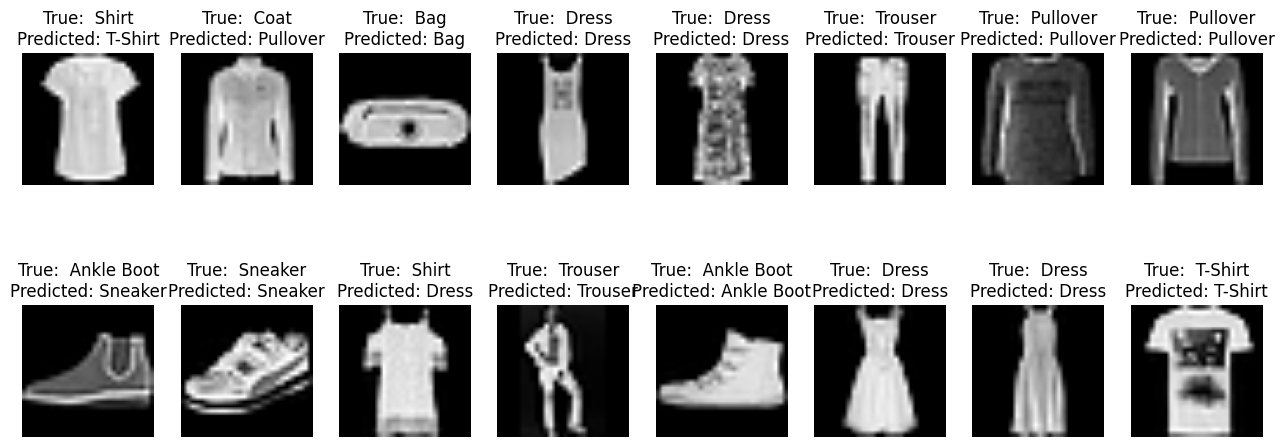

In [ ]:
cols, rows = 8, 2
figure = plt.figure(figsize=(cols*2, rows*3))
with torch.no_grad():
    for i in range(0, cols*rows):
        image_index = random.randint(0, len(test_data)-1)
        image, real_label = test_data[image_index]
        
        outputs = irn1(image.reshape(1, 1, 84, 84).to("cuda"))
        
        predicted_label = outputs.argmax(dim=-1).detach().cpu()

        figure.add_subplot(rows, cols, i+1)
        plt.title("True:  "+labels_map[int(real_label)]+"\nPredicted: "+labels_map[int(predicted_label)])
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap="gray")
    plt.show()


In [ ]:
!zip /content/weights.zip /content/irn1_weights_*.pth

  adding: content/irn1_weights_0.pth (deflated 8%)
  adding: content/irn1_weights_10.pth (deflated 8%)
  adding: content/irn1_weights_11.pth (deflated 8%)
  adding: content/irn1_weights_12.pth (deflated 8%)
  adding: content/irn1_weights_13.pth (deflated 8%)
  adding: content/irn1_weights_14.pth (deflated 8%)
  adding: content/irn1_weights_15.pth (deflated 8%)
  adding: content/irn1_weights_16.pth (deflated 8%)
  adding: content/irn1_weights_17.pth (deflated 8%)
  adding: content/irn1_weights_18.pth (deflated 8%)
  adding: content/irn1_weights_19.pth (deflated 8%)
  adding: content/irn1_weights_1.pth (deflated 8%)
  adding: content/irn1_weights_20.pth (deflated 8%)
  adding: content/irn1_weights_21.pth (deflated 8%)
  adding: content/irn1_weights_22.pth (deflated 8%)
  adding: content/irn1_weights_23.pth (deflated 8%)
  adding: content/irn1_weights_24.pth (deflated 8%)
  adding: content/irn1_weights_2.pth (deflated 8%)
  adding: content/irn1_weights_3.pth (deflated 8%)
  adding: conten

In [46]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/weights.zip /content/drive/MyDrive/irn1_weights.zip

In [38]:
torch.save(irn1.state_dict(), f'/content/drive/MyDrive/irn1_weights.pth')

In [47]:
irn1.load_state_dict(torch.load(f'/content/drive/MyDrive/irn1_weights.pth'))

<All keys matched successfully>

# Siamese

In [107]:
class SiameseDataset(Dataset):
    def __init__(self, data):
        self.data = data

        self.labels = np.unique(data.targets)
        self.data_groupby_label = {i: np.argwhere(data.targets==i).flatten() for i in self.labels}

    def __len__(self):
        return 2*len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx//2]

        if idx % 2 == 0: # same group
            other_i = random.choice(self.data_groupby_label[label])#random.randint(0, len(self.data_groupby_label[label]) - 1)

            img2 = self.data[other_i][0].reshape(1, 84, 84)
            return img, img2, torch.FloatTensor([1])
        else:
            other_label = random.choice([l for l in self.labels if l != label])
            other_i = random.choice(self.data_groupby_label[other_label])#random.randint(0, len(self.data_groupby_label[other_label]))
            img2 = self.data[other_i][0].reshape(1, 84, 84)
            return img, img2, torch.FloatTensor([0])

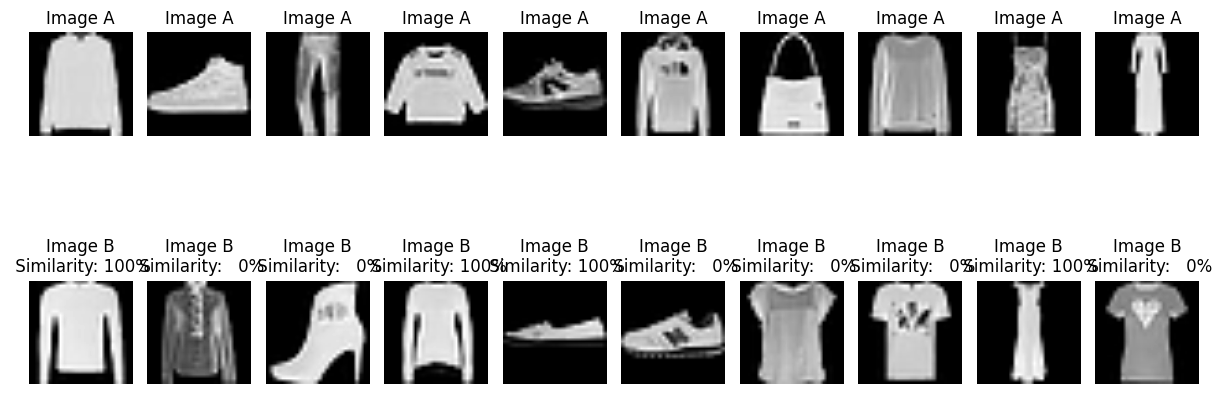

In [115]:
train_dataloader_s_demo = DataLoader(SiameseDataset(training_data), batch_size=10, shuffle=True)

for pv_a, pv_b, pv_sim in train_dataloader_s_demo:
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
        ax1.imshow(c_a.squeeze(), cmap="gray")
        ax1.set_title('Image A')
        ax1.axis('off')
        ax2.imshow(c_b.squeeze(), cmap="gray")
        ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
        ax2.axis('off')

    fig.tight_layout()

    break

In [116]:
class SiameseInceptionResNet1(nn.Module):
    def __init__(self):
        super(SiameseInceptionResNet1, self).__init__()

        self.inceptionResNet = InceptionResNet1(head=nn.Identity()).to("cuda")
        self.linear0 = nn.Linear(2 * 1792, 256)
        self.linear1 = nn.Linear(256, 1)

    def forward(self, x0, x1):
        x0 = self.inceptionResNet(x0)

        x1 = self.inceptionResNet(x1)

        x = torch.cat((x0, x1), dim=1)

        logits = nn.functional.relu(self.linear0(x))

        return nn.functional.sigmoid(self.linear1(logits))

In [117]:
siamese_model = SiameseInceptionResNet1().to("cuda")
summary(siamese_model)

Layer (type:depth-idx)                   Param #
SiameseInceptionResNet1                  --
├─InceptionResNet1: 1-1                  --
│    └─Sequential: 2-1                   --
│    │    └─Stem: 3-1                    614,320
│    │    └─InceptionResNetA: 3-2        77,248
│    │    └─InceptionResNetA: 3-3        77,248
│    │    └─InceptionResNetA: 3-4        77,248
│    │    └─InceptionResNetA: 3-5        77,248
│    │    └─InceptionResNetA: 3-6        77,248
│    │    └─ReductionA: 3-7              1,733,888
│    │    └─InceptionResNetB: 3-8        689,536
│    │    └─InceptionResNetB: 3-9        689,536
│    │    └─InceptionResNetB: 3-10       689,536
│    │    └─InceptionResNetB: 3-11       689,536
│    │    └─InceptionResNetB: 3-12       689,536
│    │    └─InceptionResNetB: 3-13       689,536
│    │    └─InceptionResNetB: 3-14       689,536
│    │    └─InceptionResNetB: 3-15       689,536
│    │    └─InceptionResNetB: 3-16       689,536
│    │    └─InceptionResNetB: 3-17    

In [118]:
siamese_model.inceptionResNet.inceptionResNet1 = irn1.inceptionResNet1

In [119]:
train_dataloader_s = DataLoader(SiameseDataset(training_data), batch_size=128, shuffle=True)
test_dataloader_s = DataLoader(SiameseDataset(test_data), batch_size=128, shuffle=True)

In [130]:
optimizer = torch.optim.SGD(siamese_model.parameters(), lr=0.001)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    train_acc = 0

    siamese_model.train(True)
    for i, data in enumerate(tqdm(train_dataloader_s)):
        img0, img1, labels = data
        img0 = img0.to("cuda")
        img1 = img1.to("cuda")
        labels = labels.to("cuda")

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = siamese_model(img0, img1)
        
        loss = nn.functional.binary_cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        predicted = outputs > 0.5
        train_acc += torch.sum(predicted == labels).item()
        
        # print statistics
        running_loss += loss.item()
        if i % 25 == 24:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f} acc: {train_acc/ 25 /labels.shape[0]:.3f} ({train_acc})')
            running_loss = 0.0
            train_acc = 0


    torch.save(siamese_model.state_dict(), f'siamese_weights_{epoch}.pth')



  3%|▎         | 25/938 [00:08<04:57,  3.07it/s]

[1,    25] loss: 0.008 acc: 0.578 (1850)


  5%|▌         | 50/938 [00:17<05:01,  2.95it/s]

[1,    50] loss: 0.008 acc: 0.674 (2157)


  8%|▊         | 75/938 [00:25<04:58,  2.89it/s]

[1,    75] loss: 0.007 acc: 0.710 (2272)


 11%|█         | 100/938 [00:34<04:35,  3.04it/s]

[1,   100] loss: 0.007 acc: 0.720 (2305)


 13%|█▎        | 125/938 [00:43<04:46,  2.84it/s]

[1,   125] loss: 0.007 acc: 0.740 (2367)


 16%|█▌        | 150/938 [00:51<04:16,  3.08it/s]

[1,   150] loss: 0.006 acc: 0.755 (2415)


 19%|█▊        | 175/938 [01:00<04:13,  3.01it/s]

[1,   175] loss: 0.006 acc: 0.771 (2468)


 21%|██▏       | 200/938 [01:09<06:10,  1.99it/s]

[1,   200] loss: 0.006 acc: 0.765 (2449)


 24%|██▍       | 225/938 [01:18<04:11,  2.84it/s]

[1,   225] loss: 0.006 acc: 0.786 (2515)


 27%|██▋       | 250/938 [01:29<04:09,  2.76it/s]

[1,   250] loss: 0.006 acc: 0.777 (2488)


 29%|██▉       | 275/938 [01:38<03:52,  2.86it/s]

[1,   275] loss: 0.006 acc: 0.780 (2496)


 32%|███▏      | 300/938 [01:46<03:33,  2.99it/s]

[1,   300] loss: 0.006 acc: 0.791 (2532)


 35%|███▍      | 325/938 [01:55<03:27,  2.96it/s]

[1,   325] loss: 0.006 acc: 0.799 (2557)


 37%|███▋      | 350/938 [02:06<04:42,  2.08it/s]

[1,   350] loss: 0.005 acc: 0.809 (2588)


 40%|███▉      | 375/938 [02:15<03:32,  2.65it/s]

[1,   375] loss: 0.005 acc: 0.813 (2602)


 43%|████▎     | 400/938 [02:24<03:02,  2.95it/s]

[1,   400] loss: 0.005 acc: 0.813 (2602)


 45%|████▌     | 425/938 [02:34<03:46,  2.26it/s]

[1,   425] loss: 0.005 acc: 0.821 (2626)


 48%|████▊     | 450/938 [02:43<02:58,  2.73it/s]

[1,   450] loss: 0.005 acc: 0.807 (2582)


 51%|█████     | 475/938 [02:52<02:36,  2.96it/s]

[1,   475] loss: 0.005 acc: 0.807 (2584)


 53%|█████▎    | 500/938 [03:05<04:10,  1.75it/s]

[1,   500] loss: 0.005 acc: 0.823 (2635)


 56%|█████▌    | 525/938 [03:14<02:27,  2.80it/s]

[1,   525] loss: 0.005 acc: 0.832 (2661)


 59%|█████▊    | 550/938 [03:22<02:07,  3.04it/s]

[1,   550] loss: 0.005 acc: 0.818 (2619)


 61%|██████▏   | 575/938 [03:31<02:02,  2.96it/s]

[1,   575] loss: 0.005 acc: 0.818 (2619)


 64%|██████▍   | 600/938 [03:39<02:02,  2.76it/s]

[1,   600] loss: 0.005 acc: 0.814 (2605)


 67%|██████▋   | 625/938 [03:47<01:43,  3.03it/s]

[1,   625] loss: 0.005 acc: 0.823 (2635)


 69%|██████▉   | 650/938 [03:56<01:44,  2.74it/s]

[1,   650] loss: 0.005 acc: 0.813 (2601)


 72%|███████▏  | 675/938 [04:05<01:33,  2.82it/s]

[1,   675] loss: 0.005 acc: 0.824 (2637)


 75%|███████▍  | 700/938 [04:14<01:17,  3.07it/s]

[1,   700] loss: 0.005 acc: 0.830 (2656)


 77%|███████▋  | 725/938 [04:22<01:12,  2.94it/s]

[1,   725] loss: 0.005 acc: 0.825 (2639)


 80%|███████▉  | 750/938 [04:32<01:15,  2.50it/s]

[1,   750] loss: 0.005 acc: 0.832 (2663)


 83%|████████▎ | 775/938 [04:40<00:52,  3.08it/s]

[1,   775] loss: 0.005 acc: 0.837 (2677)


 85%|████████▌ | 800/938 [04:49<00:52,  2.65it/s]

[1,   800] loss: 0.005 acc: 0.829 (2652)


 88%|████████▊ | 825/938 [04:58<00:37,  3.03it/s]

[1,   825] loss: 0.005 acc: 0.829 (2652)


 91%|█████████ | 850/938 [05:06<00:28,  3.05it/s]

[1,   850] loss: 0.005 acc: 0.837 (2679)


 93%|█████████▎| 875/938 [05:15<00:22,  2.74it/s]

[1,   875] loss: 0.004 acc: 0.847 (2711)


 96%|█████████▌| 900/938 [05:23<00:12,  3.05it/s]

[1,   900] loss: 0.005 acc: 0.835 (2673)


 99%|█████████▊| 925/938 [05:32<00:04,  2.97it/s]

[1,   925] loss: 0.005 acc: 0.838 (2681)


  3%|▎         | 25/938 [00:08<05:35,  2.72it/s]

[2,    25] loss: 0.004 acc: 0.843 (2698)


  5%|▌         | 50/938 [00:17<04:53,  3.03it/s]

[2,    50] loss: 0.005 acc: 0.832 (2661)


  8%|▊         | 75/938 [00:25<04:46,  3.01it/s]

[2,    75] loss: 0.005 acc: 0.843 (2696)


 11%|█         | 100/938 [00:34<05:00,  2.79it/s]

[2,   100] loss: 0.005 acc: 0.846 (2708)


 13%|█▎        | 125/938 [00:42<04:29,  3.02it/s]

[2,   125] loss: 0.005 acc: 0.832 (2662)


 16%|█▌        | 150/938 [00:51<04:19,  3.04it/s]

[2,   150] loss: 0.005 acc: 0.833 (2667)


 19%|█▊        | 175/938 [00:59<04:41,  2.71it/s]

[2,   175] loss: 0.004 acc: 0.848 (2714)


 21%|██▏       | 200/938 [01:08<04:04,  3.02it/s]

[2,   200] loss: 0.005 acc: 0.843 (2698)


 24%|██▍       | 225/938 [01:17<04:00,  2.97it/s]

[2,   225] loss: 0.005 acc: 0.839 (2684)


 27%|██▋       | 250/938 [01:25<03:48,  3.02it/s]

[2,   250] loss: 0.004 acc: 0.848 (2712)


 29%|██▉       | 275/938 [01:34<03:35,  3.08it/s]

[2,   275] loss: 0.004 acc: 0.842 (2693)


 32%|███▏      | 300/938 [01:42<03:56,  2.70it/s]

[2,   300] loss: 0.004 acc: 0.843 (2697)


 35%|███▍      | 325/938 [01:52<03:28,  2.94it/s]

[2,   325] loss: 0.004 acc: 0.843 (2696)


 37%|███▋      | 350/938 [02:02<03:17,  2.98it/s]

[2,   350] loss: 0.004 acc: 0.843 (2699)


 40%|███▉      | 375/938 [02:11<03:26,  2.72it/s]

[2,   375] loss: 0.004 acc: 0.845 (2704)


 43%|████▎     | 400/938 [02:20<03:33,  2.52it/s]

[2,   400] loss: 0.004 acc: 0.843 (2698)


 45%|████▌     | 425/938 [02:32<03:34,  2.40it/s]

[2,   425] loss: 0.004 acc: 0.847 (2709)


 48%|████▊     | 450/938 [02:41<03:10,  2.56it/s]

[2,   450] loss: 0.004 acc: 0.848 (2714)


 51%|█████     | 475/938 [02:50<02:49,  2.73it/s]

[2,   475] loss: 0.004 acc: 0.853 (2728)


 53%|█████▎    | 500/938 [02:59<02:24,  3.03it/s]

[2,   500] loss: 0.004 acc: 0.843 (2699)


 56%|█████▌    | 525/938 [03:07<02:33,  2.69it/s]

[2,   525] loss: 0.004 acc: 0.857 (2743)


 59%|█████▊    | 550/938 [03:17<02:37,  2.47it/s]

[2,   550] loss: 0.004 acc: 0.843 (2699)


 61%|██████▏   | 575/938 [03:27<02:00,  3.01it/s]

[2,   575] loss: 0.004 acc: 0.851 (2724)


 64%|██████▍   | 600/938 [03:36<02:03,  2.73it/s]

[2,   600] loss: 0.004 acc: 0.846 (2708)


 67%|██████▋   | 625/938 [03:46<02:50,  1.83it/s]

[2,   625] loss: 0.004 acc: 0.852 (2727)


 69%|██████▉   | 650/938 [03:57<01:45,  2.73it/s]

[2,   650] loss: 0.004 acc: 0.846 (2707)


 72%|███████▏  | 675/938 [04:06<01:34,  2.78it/s]

[2,   675] loss: 0.004 acc: 0.860 (2752)


 75%|███████▍  | 700/938 [04:16<02:13,  1.79it/s]

[2,   700] loss: 0.004 acc: 0.859 (2750)


 77%|███████▋  | 725/938 [04:27<01:17,  2.77it/s]

[2,   725] loss: 0.004 acc: 0.864 (2766)


 80%|███████▉  | 750/938 [04:37<01:02,  2.99it/s]

[2,   750] loss: 0.004 acc: 0.858 (2744)


 83%|████████▎ | 775/938 [04:46<00:59,  2.72it/s]

[2,   775] loss: 0.004 acc: 0.849 (2717)


 85%|████████▌ | 800/938 [04:56<00:47,  2.88it/s]

[2,   800] loss: 0.004 acc: 0.857 (2742)


 88%|████████▊ | 825/938 [05:04<00:37,  3.04it/s]

[2,   825] loss: 0.004 acc: 0.858 (2746)


 91%|█████████ | 850/938 [05:16<00:54,  1.62it/s]

[2,   850] loss: 0.004 acc: 0.851 (2724)


 93%|█████████▎| 875/938 [05:27<00:35,  1.76it/s]

[2,   875] loss: 0.004 acc: 0.859 (2749)


 96%|█████████▌| 900/938 [05:39<00:14,  2.66it/s]

[2,   900] loss: 0.004 acc: 0.854 (2732)


 99%|█████████▊| 925/938 [05:47<00:04,  3.00it/s]

[2,   925] loss: 0.004 acc: 0.860 (2751)


  3%|▎         | 25/938 [00:10<06:30,  2.34it/s]

[3,    25] loss: 0.004 acc: 0.853 (2728)


  5%|▌         | 50/938 [00:21<05:32,  2.67it/s]

[3,    50] loss: 0.004 acc: 0.855 (2736)


  8%|▊         | 75/938 [00:30<05:20,  2.69it/s]

[3,    75] loss: 0.004 acc: 0.855 (2735)


 11%|█         | 100/938 [00:39<04:45,  2.94it/s]

[3,   100] loss: 0.004 acc: 0.864 (2765)


 13%|█▎        | 125/938 [00:48<04:48,  2.82it/s]

[3,   125] loss: 0.004 acc: 0.853 (2730)


 16%|█▌        | 150/938 [00:57<04:41,  2.80it/s]

[3,   150] loss: 0.004 acc: 0.871 (2788)


 19%|█▊        | 175/938 [01:05<04:10,  3.05it/s]

[3,   175] loss: 0.004 acc: 0.862 (2758)


 21%|██▏       | 200/938 [01:15<04:06,  3.00it/s]

[3,   200] loss: 0.004 acc: 0.857 (2743)


 24%|██▍       | 225/938 [01:23<04:07,  2.88it/s]

[3,   225] loss: 0.004 acc: 0.858 (2746)


 27%|██▋       | 250/938 [01:36<04:36,  2.49it/s]

[3,   250] loss: 0.004 acc: 0.866 (2770)


 29%|██▉       | 275/938 [01:48<03:40,  3.00it/s]

[3,   275] loss: 0.004 acc: 0.862 (2759)


 32%|███▏      | 300/938 [01:56<03:56,  2.70it/s]

[3,   300] loss: 0.004 acc: 0.861 (2754)


 35%|███▍      | 325/938 [02:05<03:24,  3.00it/s]

[3,   325] loss: 0.004 acc: 0.863 (2762)


 37%|███▋      | 350/938 [02:13<03:14,  3.02it/s]

[3,   350] loss: 0.004 acc: 0.866 (2772)


 40%|███▉      | 375/938 [02:22<03:23,  2.77it/s]

[3,   375] loss: 0.004 acc: 0.867 (2774)


 43%|████▎     | 400/938 [02:31<03:24,  2.63it/s]

[3,   400] loss: 0.004 acc: 0.863 (2763)


 45%|████▌     | 425/938 [02:41<02:51,  2.99it/s]

[3,   425] loss: 0.004 acc: 0.868 (2776)


 48%|████▊     | 450/938 [02:50<02:56,  2.76it/s]

[3,   450] loss: 0.004 acc: 0.872 (2789)


 51%|█████     | 475/938 [02:58<02:34,  3.00it/s]

[3,   475] loss: 0.004 acc: 0.881 (2820)


 53%|█████▎    | 500/938 [03:09<02:26,  2.99it/s]

[3,   500] loss: 0.004 acc: 0.869 (2780)


 56%|█████▌    | 525/938 [03:18<02:59,  2.30it/s]

[3,   525] loss: 0.004 acc: 0.866 (2770)


 59%|█████▊    | 550/938 [03:28<02:13,  2.91it/s]

[3,   550] loss: 0.004 acc: 0.867 (2775)


 61%|██████▏   | 575/938 [03:37<02:01,  2.99it/s]

[3,   575] loss: 0.004 acc: 0.869 (2782)


 64%|██████▍   | 600/938 [03:45<02:05,  2.69it/s]

[3,   600] loss: 0.004 acc: 0.863 (2760)


 67%|██████▋   | 625/938 [03:54<01:44,  3.00it/s]

[3,   625] loss: 0.004 acc: 0.864 (2766)


 69%|██████▉   | 650/938 [04:02<01:34,  3.04it/s]

[3,   650] loss: 0.004 acc: 0.874 (2798)


 72%|███████▏  | 675/938 [04:11<01:33,  2.81it/s]

[3,   675] loss: 0.004 acc: 0.868 (2778)


 75%|███████▍  | 700/938 [04:19<01:25,  2.77it/s]

[3,   700] loss: 0.004 acc: 0.868 (2777)


 77%|███████▋  | 725/938 [04:28<01:12,  2.95it/s]

[3,   725] loss: 0.004 acc: 0.868 (2776)


 80%|███████▉  | 750/938 [04:36<01:01,  3.04it/s]

[3,   750] loss: 0.004 acc: 0.874 (2798)


 83%|████████▎ | 775/938 [04:45<00:53,  3.02it/s]

[3,   775] loss: 0.004 acc: 0.861 (2754)


 85%|████████▌ | 800/938 [04:53<00:50,  2.73it/s]

[3,   800] loss: 0.004 acc: 0.870 (2783)


 88%|████████▊ | 825/938 [05:02<00:36,  3.05it/s]

[3,   825] loss: 0.004 acc: 0.875 (2799)


 91%|█████████ | 850/938 [05:11<00:33,  2.59it/s]

[3,   850] loss: 0.004 acc: 0.862 (2758)


 93%|█████████▎| 875/938 [05:20<00:23,  2.72it/s]

[3,   875] loss: 0.004 acc: 0.858 (2745)


 96%|█████████▌| 900/938 [05:28<00:12,  3.03it/s]

[3,   900] loss: 0.004 acc: 0.874 (2798)


 99%|█████████▊| 925/938 [05:37<00:04,  3.02it/s]

[3,   925] loss: 0.004 acc: 0.871 (2788)


  3%|▎         | 25/938 [00:08<05:08,  2.96it/s]

[4,    25] loss: 0.003 acc: 0.881 (2819)


  5%|▌         | 50/938 [00:16<04:52,  3.03it/s]

[4,    50] loss: 0.004 acc: 0.869 (2780)


  8%|▊         | 75/938 [00:25<05:14,  2.74it/s]

[4,    75] loss: 0.004 acc: 0.873 (2792)


 11%|█         | 100/938 [00:34<05:00,  2.79it/s]

[4,   100] loss: 0.004 acc: 0.873 (2792)


 13%|█▎        | 125/938 [00:42<04:28,  3.03it/s]

[4,   125] loss: 0.004 acc: 0.870 (2783)


 16%|█▌        | 150/938 [00:51<04:19,  3.04it/s]

[4,   150] loss: 0.004 acc: 0.877 (2805)


 19%|█▊        | 175/938 [00:59<04:33,  2.79it/s]

[4,   175] loss: 0.004 acc: 0.872 (2790)


 21%|██▏       | 200/938 [01:08<04:02,  3.05it/s]

[4,   200] loss: 0.004 acc: 0.872 (2789)


 24%|██▍       | 225/938 [01:16<03:59,  2.98it/s]

[4,   225] loss: 0.004 acc: 0.882 (2822)


 27%|██▋       | 250/938 [01:25<04:37,  2.48it/s]

[4,   250] loss: 0.003 acc: 0.880 (2817)


 29%|██▉       | 275/938 [01:33<03:36,  3.06it/s]

[4,   275] loss: 0.004 acc: 0.863 (2763)


 32%|███▏      | 300/938 [01:42<03:43,  2.86it/s]

[4,   300] loss: 0.004 acc: 0.867 (2773)


 35%|███▍      | 325/938 [01:50<03:22,  3.03it/s]

[4,   325] loss: 0.003 acc: 0.881 (2818)


 37%|███▋      | 350/938 [01:59<03:11,  3.07it/s]

[4,   350] loss: 0.003 acc: 0.884 (2828)


 40%|███▉      | 375/938 [02:07<03:28,  2.70it/s]

[4,   375] loss: 0.004 acc: 0.884 (2830)


 43%|████▎     | 400/938 [02:16<02:55,  3.06it/s]

[4,   400] loss: 0.004 acc: 0.877 (2806)


 45%|████▌     | 425/938 [02:25<02:50,  3.01it/s]

[4,   425] loss: 0.004 acc: 0.874 (2798)


 48%|████▊     | 450/938 [02:33<02:52,  2.83it/s]

[4,   450] loss: 0.004 acc: 0.874 (2796)


 51%|█████     | 475/938 [02:42<02:34,  3.00it/s]

[4,   475] loss: 0.004 acc: 0.878 (2809)


 53%|█████▎    | 500/938 [02:50<02:29,  2.92it/s]

[4,   500] loss: 0.004 acc: 0.876 (2803)


 56%|█████▌    | 525/938 [02:58<02:16,  3.03it/s]

[4,   525] loss: 0.004 acc: 0.868 (2778)


 59%|█████▊    | 550/938 [03:08<02:25,  2.66it/s]

[4,   550] loss: 0.004 acc: 0.878 (2810)


 61%|██████▏   | 575/938 [03:16<02:13,  2.72it/s]

[4,   575] loss: 0.004 acc: 0.879 (2813)


 64%|██████▍   | 600/938 [03:24<01:51,  3.03it/s]

[4,   600] loss: 0.004 acc: 0.879 (2812)


 67%|██████▋   | 625/938 [03:33<01:42,  3.04it/s]

[4,   625] loss: 0.003 acc: 0.870 (2783)


 69%|██████▉   | 650/938 [03:41<01:44,  2.77it/s]

[4,   650] loss: 0.004 acc: 0.876 (2802)


 72%|███████▏  | 675/938 [03:50<01:26,  3.03it/s]

[4,   675] loss: 0.003 acc: 0.883 (2827)


 75%|███████▍  | 700/938 [03:58<01:25,  2.79it/s]

[4,   700] loss: 0.003 acc: 0.889 (2845)


 77%|███████▋  | 725/938 [04:07<01:11,  2.99it/s]

[4,   725] loss: 0.003 acc: 0.882 (2822)


 80%|███████▉  | 750/938 [04:16<01:02,  3.03it/s]

[4,   750] loss: 0.003 acc: 0.888 (2841)


 83%|████████▎ | 775/938 [04:24<00:59,  2.76it/s]

[4,   775] loss: 0.003 acc: 0.888 (2843)


 85%|████████▌ | 800/938 [04:33<00:46,  3.00it/s]

[4,   800] loss: 0.003 acc: 0.884 (2830)


 88%|████████▊ | 825/938 [04:41<00:37,  3.02it/s]

[4,   825] loss: 0.004 acc: 0.876 (2802)


 91%|█████████ | 850/938 [04:50<00:32,  2.75it/s]

[4,   850] loss: 0.003 acc: 0.888 (2843)


 93%|█████████▎| 875/938 [04:59<00:20,  3.05it/s]

[4,   875] loss: 0.003 acc: 0.892 (2856)


 96%|█████████▌| 900/938 [05:07<00:12,  3.01it/s]

[4,   900] loss: 0.003 acc: 0.873 (2795)


 99%|█████████▊| 925/938 [05:15<00:04,  2.87it/s]

[4,   925] loss: 0.004 acc: 0.879 (2812)


  3%|▎         | 25/938 [00:08<04:58,  3.06it/s]

[5,    25] loss: 0.003 acc: 0.891 (2850)


  5%|▌         | 50/938 [00:16<04:54,  3.02it/s]

[5,    50] loss: 0.004 acc: 0.873 (2792)


  8%|▊         | 75/938 [00:25<05:41,  2.53it/s]

[5,    75] loss: 0.003 acc: 0.888 (2843)


 11%|█         | 100/938 [00:34<04:35,  3.04it/s]

[5,   100] loss: 0.004 acc: 0.874 (2797)


 13%|█▎        | 125/938 [00:42<04:28,  3.03it/s]

[5,   125] loss: 0.003 acc: 0.881 (2819)


 16%|█▌        | 150/938 [00:51<04:54,  2.67it/s]

[5,   150] loss: 0.003 acc: 0.887 (2839)


 19%|█▊        | 175/938 [00:59<04:11,  3.04it/s]

[5,   175] loss: 0.003 acc: 0.885 (2831)


 21%|██▏       | 200/938 [01:08<04:06,  2.99it/s]

[5,   200] loss: 0.003 acc: 0.887 (2840)


 24%|██▍       | 225/938 [01:16<04:07,  2.88it/s]

[5,   225] loss: 0.004 acc: 0.873 (2794)


 27%|██▋       | 250/938 [01:25<03:47,  3.02it/s]

[5,   250] loss: 0.003 acc: 0.885 (2832)


 29%|██▉       | 275/938 [01:34<03:52,  2.85it/s]

[5,   275] loss: 0.003 acc: 0.892 (2856)


 32%|███▏      | 300/938 [01:42<03:31,  3.02it/s]

[5,   300] loss: 0.003 acc: 0.888 (2841)


 35%|███▍      | 325/938 [01:51<03:22,  3.02it/s]

[5,   325] loss: 0.003 acc: 0.876 (2803)


 37%|███▋      | 350/938 [01:59<03:37,  2.71it/s]

[5,   350] loss: 0.003 acc: 0.882 (2821)


 40%|███▉      | 375/938 [02:08<03:03,  3.07it/s]

[5,   375] loss: 0.003 acc: 0.887 (2840)


 43%|████▎     | 400/938 [02:17<03:19,  2.69it/s]

[5,   400] loss: 0.003 acc: 0.890 (2848)


 45%|████▌     | 425/938 [02:25<02:49,  3.03it/s]

[5,   425] loss: 0.003 acc: 0.886 (2836)


 48%|████▊     | 450/938 [02:34<02:40,  3.04it/s]

[5,   450] loss: 0.003 acc: 0.892 (2856)


 51%|█████     | 475/938 [02:42<02:47,  2.77it/s]

[5,   475] loss: 0.003 acc: 0.889 (2844)


 53%|█████▎    | 500/938 [02:50<02:29,  2.92it/s]

[5,   500] loss: 0.003 acc: 0.885 (2833)


 56%|█████▌    | 525/938 [02:59<02:16,  3.03it/s]

[5,   525] loss: 0.003 acc: 0.887 (2839)


 59%|█████▊    | 550/938 [03:08<02:28,  2.61it/s]

[5,   550] loss: 0.003 acc: 0.890 (2847)


 61%|██████▏   | 575/938 [03:17<01:59,  3.05it/s]

[5,   575] loss: 0.003 acc: 0.883 (2826)


 64%|██████▍   | 600/938 [03:25<02:04,  2.71it/s]

[5,   600] loss: 0.003 acc: 0.889 (2844)


 67%|██████▋   | 625/938 [03:34<01:42,  3.06it/s]

[5,   625] loss: 0.003 acc: 0.879 (2814)


 69%|██████▉   | 650/938 [03:42<01:36,  2.98it/s]

[5,   650] loss: 0.003 acc: 0.892 (2856)


 72%|███████▏  | 675/938 [03:51<01:35,  2.76it/s]

[5,   675] loss: 0.003 acc: 0.897 (2869)


 75%|███████▍  | 700/938 [03:59<01:18,  3.05it/s]

[5,   700] loss: 0.003 acc: 0.895 (2863)


 77%|███████▋  | 725/938 [04:08<01:13,  2.91it/s]

[5,   725] loss: 0.003 acc: 0.895 (2865)


 80%|███████▉  | 750/938 [04:17<01:02,  3.03it/s]

[5,   750] loss: 0.003 acc: 0.889 (2846)


 83%|████████▎ | 775/938 [04:25<00:54,  3.00it/s]

[5,   775] loss: 0.003 acc: 0.894 (2861)


 85%|████████▌ | 800/938 [04:34<00:50,  2.75it/s]

[5,   800] loss: 0.003 acc: 0.890 (2848)


 88%|████████▊ | 825/938 [04:42<00:36,  3.05it/s]

[5,   825] loss: 0.003 acc: 0.889 (2845)


 91%|█████████ | 850/938 [04:51<00:29,  2.99it/s]

[5,   850] loss: 0.003 acc: 0.898 (2874)


 93%|█████████▎| 875/938 [04:59<00:22,  2.76it/s]

[5,   875] loss: 0.003 acc: 0.882 (2824)


 96%|█████████▌| 900/938 [05:08<00:14,  2.64it/s]

[5,   900] loss: 0.003 acc: 0.891 (2851)


 99%|█████████▊| 925/938 [05:16<00:04,  2.99it/s]

[5,   925] loss: 0.003 acc: 0.888 (2843)


100%|██████████| 938/938 [05:21<00:00,  2.92it/s]


In [131]:
torch.save(siamese_model.state_dict(), f'siamese_weights.pth')

In [140]:
def test_metrics_siamese(model):
    test_acc = 0
    test_loss = 0

    true_labels = []
    predicted = []

    model.train(False)
    for img0, img1, labels in test_dataloader_s:
        true_labels.append(labels)

        outputs = model(img0.to("cuda"), img1.to("cuda"))

        test_loss += nn.functional.binary_cross_entropy(outputs, labels.to("cuda")).item()

        predicted.append((outputs>0.5).detach().cpu())

        test_acc += torch.sum((outputs>0.5) == labels.to("cuda")).item()

    f1_w = f1_score(torch.cat(true_labels), torch.cat(predicted), average="weighted")
    f1_macro = f1_score(torch.cat(true_labels), torch.cat(predicted), average="macro")


    return test_acc/len(test_data)/2, test_loss, f1_w, f1_macro

In [141]:
acc, test_loss, f1_w, f1_macro = test_metrics_siamese(siamese_model)

print(f"Trained test accuracy: {acc:.3f} F1 weighted: {f1_w:.3f} F1 macro: {f1_macro:.3f} loss: {test_loss:.3f}\n")

Trained test accuracy: 0.893 F1 weighted: 0.893 F1 macro: 0.893 loss: 39.873



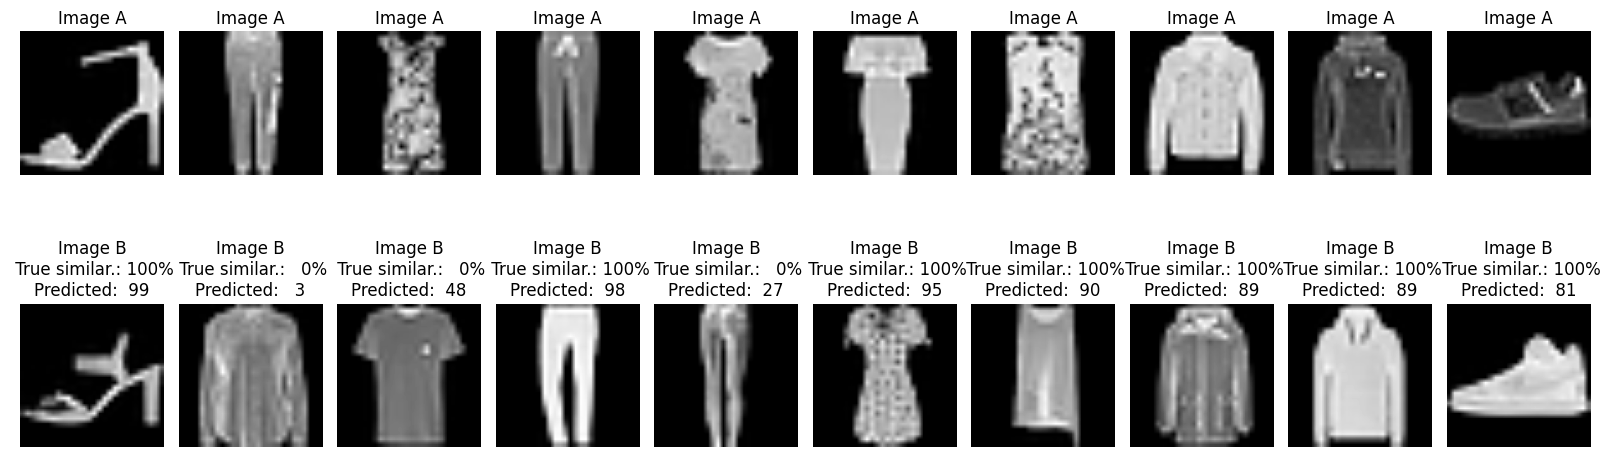

In [142]:
train_dataloader_s_demo = DataLoader(SiameseDataset(training_data), batch_size=10, shuffle=True)
test_dataloader_s_demo = DataLoader(SiameseDataset(test_data), batch_size=10, shuffle=True)

for i, (pv_a, pv_b, pv_sim) in enumerate(test_dataloader_s_demo):
    outputs = siamese_model(pv_a.to("cuda"), pv_b.to("cuda"))

    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (16, 6))
    for c_a, c_b, c_d, out, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, outputs, m_axs.T):
        c_d = c_d.item()
        out = out.item()

        ax1.imshow(c_a.squeeze(), cmap="gray")
        ax1.set_title('Image A')
        ax1.axis('off')
        ax2.imshow(c_b.squeeze(), cmap="gray")
        ax2.set_title(f'Image B\n True similar.: {100*c_d:3.0f}%\nPredicted: {100*out:3.0f}')
        ax2.axis('off')

    fig.tight_layout()

    fig.show()
    break

In [154]:
def generate_features(model):
    x_test_features = []
    labels_ = []
    for img0, labels in test_dataloader:
        outputs = model.inceptionResNet(img0.to("cuda"))
        x_test_features.append(outputs.detach().cpu())
        labels_.append(labels)

    return torch.cat(x_test_features), torch.cat(labels_)

In [155]:
x_test_features, labels = generate_features(siamese_model)

In [156]:
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
init='pca',
random_state=101,
method='barnes_hut',
n_iter=500,
verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 13.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 18.319394
[t-SNE] Computed conditional probabilities in 0.365s
[t-SNE] Iteration 50: error = 84.2505493, gradient norm = 0.0230380 (50 iterations in 5.018s)
[t-SNE] 

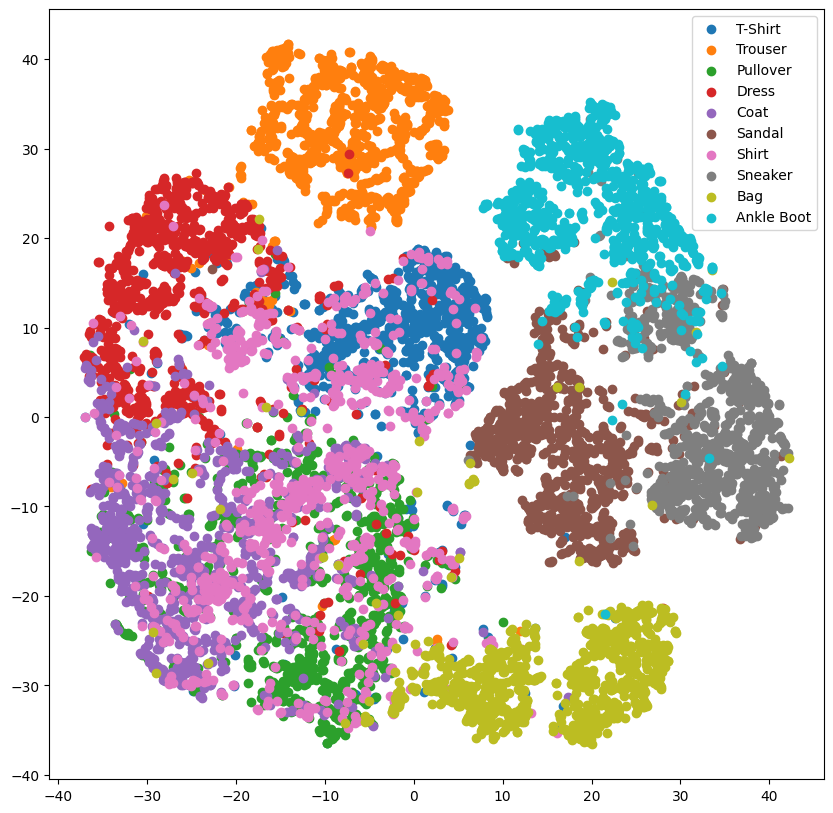

In [159]:
plt.figure(figsize=(10, 10))
for i in range(10):
    indices = np.where(labels == i)[0]
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=labels_map[i])
plt.legend()
plt.show()

In [153]:
labels

tensor([[0.],
        [0.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])